<a href="https://colab.research.google.com/github/Asmaasa3d/Pose-Detection-project/blob/main/data_of_Pose_Detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Thanks to:
- Amira Adel Foda
- Asmaa Said

From ITI Intake 42 Smart Village branch AI-Pro track Group 2

## All data to csv file

#### data download link  👇
http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip 

#### Anlges extraction is inspired from this repo
https://github.com/natanielruiz/deep-head-pose.git


In [1]:
# !unzip AFLW2000-3D.zip

In [2]:
# !pip install opencv-python

In [3]:
# !pip install cmake 


In [4]:
# !pip install dlib --user

In [5]:
# import dlib


In [6]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import cv2
import dlib

In [7]:
mylist = [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]

In [8]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines


In [9]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [10]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [11]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index]

    def __len__(self):
        # 2,000
        return self.length






In [38]:
demo=AFLW2000("AFLW2000/*.mat",'AFLW2000/')

In [13]:
features=[]
labels=[]
imgs=[]
for i in range(2000):
    features.append(demo.__getitem__(i)[1])
    x = np.array(demo.__getitem__(i)[2], dtype=np.float32)
    labels.append(x)
    imgs.append(demo.__getitem__(i)[3])



In [14]:
print(imgs[0])
print(features[0])
print(labels[0])

image00002
[33 25 34]
[  1.044306  -22.874239    4.9088855]


In [15]:
data = np.array(features, dtype=np.float32)

In [16]:
labels = np.array(labels, dtype=np.float32)

In [17]:
data1=np.concatenate((data,labels),axis=1)

In [18]:

df = pd.DataFrame(data1,columns=['x','y','z','yaw', 'pitch', 'roll']) #convert to a dataframe


In [19]:
df['img']=imgs

In [20]:
df

,x,y,z,yaw,pitch,roll,img
0,33.0,25.0,34.0,1.044306,-22.874239,4.908885,image00002
1,55.0,41.0,38.0,68.155243,26.932743,17.243670,image00004
2,49.0,29.0,28.0,50.485413,-10.579652,-13.570645,image00006
3,38.0,29.0,25.0,17.143373,-10.048455,-21.392782,image00008
4,55.0,16.0,13.0,68.640549,-50.544582,-59.207973,image00010
...,...,...,...,...,...,...,...
1995,31.0,29.0,35.0,-4.035367,-11.293093,6.022806,image04358
1996,5.0,28.0,36.0,-81.288437,-13.327947,10.081747,image04363
1997,60.0,5.0,4.0,82.005562,-82.961685,-86.483292,image04364
1998,10.0,24.0,41.0,-68.249336,-24.090857,25.869925,image04365


In [21]:
df.to_csv("testfile",index=False) #save to file

#Then, to reload:
df = pd.read_csv("testfile")

##Demo on one image

In [22]:
def getitem(index,mat_path,image_mode='RGB'):
        ## index jpg inamge
        ##mat_path .mat image
        img = Image.open(index)
        img = img.convert(image_mode)
    
        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]

        # if transform is not None:
        #     img = transform(img)

        return img, labels, cont_labels, index


In [23]:
getitem('AFLW2000/image00002.jpg','AFLW2000/image00002.mat')

(<PIL.Image.Image image mode=RGB size=628x427 at 0x295001D4220>,
 array([33, 25, 34], dtype=int64),
 [1.044306042017331, -22.874238643575588, 4.908885557905314],
 'AFLW2000/image00002.jpg')

## draw axis

In [24]:
# from google.colab.patches import cv2_imshow

In [25]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [26]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [27]:
# !wget http://arunponnusamy.com/files/mmod_human_face_detector.dat

In [28]:
# !bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

In [3]:
predictor=dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()


In [30]:
# cv2.destroyAllWindows()
# # model='/content/mmod_human_face_detector.dat'

# cnn_face_detector = dlib.cnn_face_detection_model_v1(model)
# image='/content/AFLW2000/image04153.jpg'
# frame = cv2.imread(image)

# cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# dets = cnn_face_detector(cv2_frame, 1)
# for (idx, det) in enumerate(dets):
#             # Get x_min, y_min, x_max, y_max, conf
#             x_min = det.rect.left()
#             y_min = det.rect.top()
#             x_max = det.rect.right()
#             y_max = det.rect.bottom()
#             # conf = det.confidence
#             # print(det)
#             shape = predictor(cv2_frame, det.rect)
#             tdx,tdy=shape.part(33).x, shape.part(33).y
#             bbox_height, bbox_width = frame.shape[:2]
           
#             cv2.destroyAllWindows()
#             cv2_imshow(draw_axis(frame,-64,12 ,-10,tdx,tdy)
#             )
# cv2.destroyAllWindows()


In [32]:
# import cv2
# import dlib
# image='AFLW2000/image04153.jpg'
# frame = cv2.imread(image)

# cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# dets = cnn_face_detector(cv2_frame, 1)
# for (idx, det) in enumerate(dets):
#             # Get x_min, y_min, x_max, y_max, conf
#             x_min = det.left()
#             y_min = det.top()
#             x_max = det.right()-x_min
#             y_max = det.bottom()-y_min
#             # conf = det.confidence
#             # print(det)

#             shape = predictor(cv2_frame, det)
#             tdx,tdy=shape.part(30).x, shape.part(30).y
#             bbox_height, bbox_width = frame.shape[:2]
           
#             cv2.destroyAllWindows()
#             cv2_imshow(draw_axis(frame,-64,12 ,-10,tdx,tdy))
# #             cv2.imshow("Face Landmarks", frame)
# cv2.destroyAllWindows()


In [ ]:
cap = cv2.VideoCapture(0)

hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = hog_face_detector(gray)
    for face in faces:

        face_landmarks = dlib_facelandmark(gray, face)
#         print(face_landmarks)

        for n in range(0, 68):
            x = face_landmarks.part(n).x
            y = face_landmarks.part(n).y
            cv2.circle(frame, (x, y), 1, (0, 255, 255), 1)
#             print("X , y : " , f" ({x} ,{y})" , f"------> {n}")
#             if n == 67:
#                 print("*************")


    cv2.imshow("Face Landmarks", frame)

    key = cv2.waitKey(5)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()

X , y :   (267 ,298) ------> 0
X , y :   (270 ,326) ------> 1
X , y :   (276 ,352) ------> 2
X , y :   (282 ,379) ------> 3
X , y :   (292 ,406) ------> 4
X , y :   (308 ,430) ------> 5
X , y :   (328 ,452) ------> 6
X , y :   (353 ,470) ------> 7
X , y :   (384 ,473) ------> 8
X , y :   (413 ,465) ------> 9
X , y :   (435 ,444) ------> 10
X , y :   (450 ,418) ------> 11
X , y :   (461 ,389) ------> 12
X , y :   (464 ,359) ------> 13
X , y :   (465 ,329) ------> 14
X , y :   (464 ,301) ------> 15
X , y :   (460 ,274) ------> 16
X , y :   (280 ,280) ------> 17
X , y :   (288 ,262) ------> 18
X , y :   (306 ,252) ------> 19
X , y :   (327 ,251) ------> 20
X , y :   (347 ,256) ------> 21
X , y :   (377 ,252) ------> 22
X , y :   (396 ,242) ------> 23
X , y :   (416 ,239) ------> 24
X , y :   (436 ,245) ------> 25
X , y :   (446 ,260) ------> 26
X , y :   (366 ,278) ------> 27
X , y :   (369 ,299) ------> 28
X , y :   (371 ,319) ------> 29
X , y :   (374 ,341) ------> 30
X , y :   (353 ,35

X , y :   (268 ,368) ------> 3
X , y :   (277 ,392) ------> 4
X , y :   (292 ,416) ------> 5
X , y :   (312 ,435) ------> 6
X , y :   (337 ,448) ------> 7
X , y :   (367 ,449) ------> 8
X , y :   (395 ,442) ------> 9
X , y :   (416 ,424) ------> 10
X , y :   (430 ,402) ------> 11
X , y :   (439 ,375) ------> 12
X , y :   (442 ,348) ------> 13
X , y :   (444 ,322) ------> 14
X , y :   (443 ,296) ------> 15
X , y :   (439 ,272) ------> 16
X , y :   (264 ,272) ------> 17
X , y :   (273 ,255) ------> 18
X , y :   (290 ,248) ------> 19
X , y :   (309 ,247) ------> 20
X , y :   (327 ,252) ------> 21
X , y :   (358 ,247) ------> 22
X , y :   (375 ,238) ------> 23
X , y :   (394 ,236) ------> 24
X , y :   (412 ,240) ------> 25
X , y :   (424 ,253) ------> 26
X , y :   (345 ,273) ------> 27
X , y :   (347 ,293) ------> 28
X , y :   (349 ,313) ------> 29
X , y :   (351 ,333) ------> 30
X , y :   (332 ,349) ------> 31
X , y :   (342 ,352) ------> 32
X , y :   (354 ,354) ------> 33
X , y :   (365 

X , y :   (348 ,399) ------> 57
X , y :   (336 ,400) ------> 58
X , y :   (323 ,398) ------> 59
X , y :   (313 ,390) ------> 60
X , y :   (333 ,388) ------> 61
X , y :   (345 ,388) ------> 62
X , y :   (356 ,385) ------> 63
X , y :   (378 ,381) ------> 64
X , y :   (357 ,385) ------> 65
X , y :   (346 ,389) ------> 66
X , y :   (334 ,388) ------> 67
*************
X , y :   (245 ,297) ------> 0
X , y :   (250 ,323) ------> 1
X , y :   (256 ,348) ------> 2
X , y :   (263 ,374) ------> 3
X , y :   (272 ,398) ------> 4
X , y :   (287 ,421) ------> 5
X , y :   (308 ,439) ------> 6
X , y :   (333 ,453) ------> 7
X , y :   (362 ,453) ------> 8
X , y :   (389 ,445) ------> 9
X , y :   (410 ,426) ------> 10
X , y :   (424 ,403) ------> 11
X , y :   (433 ,376) ------> 12
X , y :   (436 ,348) ------> 13
X , y :   (435 ,321) ------> 14
X , y :   (433 ,294) ------> 15
X , y :   (430 ,268) ------> 16
X , y :   (255 ,277) ------> 17
X , y :   (263 ,259) ------> 18
X , y :   (280 ,251) ------> 19
X , 

X , y :   (248 ,301) ------> 0
X , y :   (252 ,327) ------> 1
X , y :   (259 ,353) ------> 2
X , y :   (266 ,379) ------> 3
X , y :   (277 ,404) ------> 4
X , y :   (292 ,429) ------> 5
X , y :   (312 ,449) ------> 6
X , y :   (338 ,463) ------> 7
X , y :   (367 ,463) ------> 8
X , y :   (394 ,454) ------> 9
X , y :   (415 ,434) ------> 10
X , y :   (430 ,410) ------> 11
X , y :   (439 ,382) ------> 12
X , y :   (442 ,353) ------> 13
X , y :   (442 ,325) ------> 14
X , y :   (440 ,298) ------> 15
X , y :   (435 ,271) ------> 16
X , y :   (258 ,282) ------> 17
X , y :   (265 ,263) ------> 18
X , y :   (282 ,255) ------> 19
X , y :   (302 ,255) ------> 20
X , y :   (321 ,260) ------> 21
X , y :   (350 ,254) ------> 22
X , y :   (368 ,244) ------> 23
X , y :   (388 ,239) ------> 24
X , y :   (407 ,243) ------> 25
X , y :   (419 ,258) ------> 26
X , y :   (339 ,279) ------> 27
X , y :   (342 ,300) ------> 28
X , y :   (344 ,321) ------> 29
X , y :   (347 ,343) ------> 30
X , y :   (329 ,35

X , y :   (248 ,301) ------> 0
X , y :   (252 ,328) ------> 1
X , y :   (258 ,353) ------> 2
X , y :   (265 ,379) ------> 3
X , y :   (275 ,404) ------> 4
X , y :   (290 ,428) ------> 5
X , y :   (310 ,448) ------> 6
X , y :   (335 ,462) ------> 7
X , y :   (365 ,463) ------> 8
X , y :   (392 ,455) ------> 9
X , y :   (412 ,435) ------> 10
X , y :   (426 ,410) ------> 11
X , y :   (436 ,383) ------> 12
X , y :   (439 ,355) ------> 13
X , y :   (439 ,327) ------> 14
X , y :   (437 ,299) ------> 15
X , y :   (432 ,273) ------> 16
X , y :   (257 ,281) ------> 17
X , y :   (265 ,263) ------> 18
X , y :   (282 ,255) ------> 19
X , y :   (301 ,254) ------> 20
X , y :   (320 ,259) ------> 21
X , y :   (348 ,254) ------> 22
X , y :   (366 ,244) ------> 23
X , y :   (385 ,240) ------> 24
X , y :   (404 ,244) ------> 25
X , y :   (416 ,259) ------> 26
X , y :   (337 ,279) ------> 27
X , y :   (339 ,300) ------> 28
X , y :   (342 ,322) ------> 29
X , y :   (344 ,343) ------> 30
X , y :   (326 ,35

X , y :   (247 ,301) ------> 0
X , y :   (250 ,328) ------> 1
X , y :   (257 ,354) ------> 2
X , y :   (265 ,381) ------> 3
X , y :   (276 ,406) ------> 4
X , y :   (292 ,430) ------> 5
X , y :   (313 ,450) ------> 6
X , y :   (338 ,464) ------> 7
X , y :   (366 ,464) ------> 8
X , y :   (393 ,456) ------> 9
X , y :   (413 ,435) ------> 10
X , y :   (427 ,410) ------> 11
X , y :   (435 ,382) ------> 12
X , y :   (438 ,353) ------> 13
X , y :   (438 ,326) ------> 14
X , y :   (436 ,298) ------> 15
X , y :   (432 ,272) ------> 16
X , y :   (256 ,282) ------> 17
X , y :   (263 ,263) ------> 18
X , y :   (280 ,255) ------> 19
X , y :   (299 ,255) ------> 20
X , y :   (318 ,260) ------> 21
X , y :   (347 ,254) ------> 22
X , y :   (365 ,244) ------> 23
X , y :   (384 ,240) ------> 24
X , y :   (404 ,244) ------> 25
X , y :   (416 ,258) ------> 26
X , y :   (336 ,279) ------> 27
X , y :   (339 ,300) ------> 28
X , y :   (341 ,321) ------> 29
X , y :   (344 ,343) ------> 30
X , y :   (326 ,35

X , y :   (301 ,254) ------> 20
X , y :   (319 ,259) ------> 21
X , y :   (349 ,253) ------> 22
X , y :   (367 ,244) ------> 23
X , y :   (386 ,240) ------> 24
X , y :   (406 ,244) ------> 25
X , y :   (418 ,259) ------> 26
X , y :   (338 ,278) ------> 27
X , y :   (340 ,300) ------> 28
X , y :   (343 ,321) ------> 29
X , y :   (345 ,343) ------> 30
X , y :   (326 ,358) ------> 31
X , y :   (337 ,361) ------> 32
X , y :   (348 ,363) ------> 33
X , y :   (359 ,357) ------> 34
X , y :   (369 ,351) ------> 35
X , y :   (282 ,300) ------> 36
X , y :   (291 ,297) ------> 37
X , y :   (302 ,294) ------> 38
X , y :   (314 ,293) ------> 39
X , y :   (304 ,300) ------> 40
X , y :   (293 ,303) ------> 41
X , y :   (366 ,285) ------> 42
X , y :   (377 ,283) ------> 43
X , y :   (388 ,282) ------> 44
X , y :   (398 ,282) ------> 45
X , y :   (389 ,288) ------> 46
X , y :   (378 ,289) ------> 47
X , y :   (317 ,401) ------> 48
X , y :   (328 ,395) ------> 49
X , y :   (340 ,390) ------> 50
X , y : 

X , y :   (258 ,351) ------> 2
X , y :   (265 ,378) ------> 3
X , y :   (275 ,403) ------> 4
X , y :   (291 ,428) ------> 5
X , y :   (312 ,449) ------> 6
X , y :   (338 ,464) ------> 7
X , y :   (368 ,464) ------> 8
X , y :   (395 ,455) ------> 9
X , y :   (415 ,435) ------> 10
X , y :   (428 ,409) ------> 11
X , y :   (437 ,381) ------> 12
X , y :   (440 ,353) ------> 13
X , y :   (440 ,325) ------> 14
X , y :   (438 ,298) ------> 15
X , y :   (434 ,272) ------> 16
X , y :   (259 ,281) ------> 17
X , y :   (267 ,262) ------> 18
X , y :   (284 ,254) ------> 19
X , y :   (303 ,253) ------> 20
X , y :   (321 ,258) ------> 21
X , y :   (351 ,253) ------> 22
X , y :   (369 ,244) ------> 23
X , y :   (388 ,240) ------> 24
X , y :   (407 ,244) ------> 25
X , y :   (419 ,258) ------> 26
X , y :   (340 ,278) ------> 27
X , y :   (342 ,300) ------> 28
X , y :   (345 ,321) ------> 29
X , y :   (347 ,342) ------> 30
X , y :   (329 ,357) ------> 31
X , y :   (339 ,360) ------> 32
X , y :   (351 ,

X , y :   (248 ,299) ------> 0
X , y :   (252 ,325) ------> 1
X , y :   (259 ,352) ------> 2
X , y :   (267 ,378) ------> 3
X , y :   (277 ,403) ------> 4
X , y :   (293 ,428) ------> 5
X , y :   (314 ,449) ------> 6
X , y :   (340 ,464) ------> 7
X , y :   (370 ,464) ------> 8
X , y :   (396 ,455) ------> 9
X , y :   (416 ,434) ------> 10
X , y :   (430 ,408) ------> 11
X , y :   (438 ,380) ------> 12
X , y :   (441 ,352) ------> 13
X , y :   (440 ,324) ------> 14
X , y :   (438 ,296) ------> 15
X , y :   (434 ,270) ------> 16
X , y :   (258 ,280) ------> 17
X , y :   (266 ,262) ------> 18
X , y :   (283 ,254) ------> 19
X , y :   (302 ,253) ------> 20
X , y :   (321 ,257) ------> 21
X , y :   (351 ,252) ------> 22
X , y :   (369 ,243) ------> 23
X , y :   (388 ,239) ------> 24
X , y :   (406 ,243) ------> 25
X , y :   (418 ,257) ------> 26
X , y :   (339 ,277) ------> 27
X , y :   (342 ,299) ------> 28
X , y :   (344 ,319) ------> 29
X , y :   (347 ,341) ------> 30
X , y :   (329 ,35

X , y :   (249 ,299) ------> 0
X , y :   (253 ,325) ------> 1
X , y :   (259 ,351) ------> 2
X , y :   (267 ,377) ------> 3
X , y :   (277 ,403) ------> 4
X , y :   (293 ,427) ------> 5
X , y :   (313 ,448) ------> 6
X , y :   (339 ,463) ------> 7
X , y :   (369 ,464) ------> 8
X , y :   (396 ,455) ------> 9
X , y :   (416 ,434) ------> 10
X , y :   (429 ,408) ------> 11
X , y :   (438 ,380) ------> 12
X , y :   (441 ,352) ------> 13
X , y :   (440 ,325) ------> 14
X , y :   (439 ,298) ------> 15
X , y :   (435 ,272) ------> 16
X , y :   (260 ,282) ------> 17
X , y :   (266 ,263) ------> 18
X , y :   (283 ,254) ------> 19
X , y :   (302 ,253) ------> 20
X , y :   (321 ,257) ------> 21
X , y :   (350 ,252) ------> 22
X , y :   (369 ,243) ------> 23
X , y :   (389 ,239) ------> 24
X , y :   (408 ,244) ------> 25
X , y :   (419 ,259) ------> 26
X , y :   (340 ,278) ------> 27
X , y :   (342 ,299) ------> 28
X , y :   (345 ,319) ------> 29
X , y :   (347 ,341) ------> 30
X , y :   (328 ,35

X , y :   (249 ,299) ------> 0
X , y :   (253 ,325) ------> 1
X , y :   (260 ,351) ------> 2
X , y :   (267 ,377) ------> 3
X , y :   (277 ,402) ------> 4
X , y :   (293 ,427) ------> 5
X , y :   (313 ,447) ------> 6
X , y :   (339 ,462) ------> 7
X , y :   (368 ,463) ------> 8
X , y :   (396 ,454) ------> 9
X , y :   (416 ,433) ------> 10
X , y :   (429 ,408) ------> 11
X , y :   (438 ,380) ------> 12
X , y :   (441 ,352) ------> 13
X , y :   (440 ,325) ------> 14
X , y :   (438 ,298) ------> 15
X , y :   (434 ,272) ------> 16
X , y :   (259 ,280) ------> 17
X , y :   (267 ,262) ------> 18
X , y :   (283 ,254) ------> 19
X , y :   (302 ,253) ------> 20
X , y :   (321 ,257) ------> 21
X , y :   (351 ,252) ------> 22
X , y :   (369 ,243) ------> 23
X , y :   (388 ,239) ------> 24
X , y :   (406 ,243) ------> 25
X , y :   (418 ,257) ------> 26
X , y :   (340 ,277) ------> 27
X , y :   (342 ,298) ------> 28
X , y :   (345 ,319) ------> 29
X , y :   (348 ,340) ------> 30
X , y :   (329 ,35

X , y :   (247 ,299) ------> 0
X , y :   (252 ,326) ------> 1
X , y :   (258 ,353) ------> 2
X , y :   (266 ,379) ------> 3
X , y :   (277 ,404) ------> 4
X , y :   (293 ,428) ------> 5
X , y :   (313 ,448) ------> 6
X , y :   (339 ,461) ------> 7
X , y :   (368 ,462) ------> 8
X , y :   (394 ,453) ------> 9
X , y :   (414 ,433) ------> 10
X , y :   (428 ,409) ------> 11
X , y :   (437 ,381) ------> 12
X , y :   (440 ,353) ------> 13
X , y :   (439 ,326) ------> 14
X , y :   (438 ,298) ------> 15
X , y :   (434 ,272) ------> 16
X , y :   (259 ,280) ------> 17
X , y :   (267 ,261) ------> 18
X , y :   (284 ,253) ------> 19
X , y :   (303 ,252) ------> 20
X , y :   (321 ,258) ------> 21
X , y :   (350 ,252) ------> 22
X , y :   (368 ,243) ------> 23
X , y :   (388 ,239) ------> 24
X , y :   (406 ,242) ------> 25
X , y :   (418 ,257) ------> 26
X , y :   (339 ,276) ------> 27
X , y :   (342 ,298) ------> 28
X , y :   (344 ,319) ------> 29
X , y :   (347 ,340) ------> 30
X , y :   (328 ,35

X , y :   (248 ,299) ------> 0
X , y :   (251 ,325) ------> 1
X , y :   (258 ,351) ------> 2
X , y :   (266 ,377) ------> 3
X , y :   (276 ,402) ------> 4
X , y :   (291 ,427) ------> 5
X , y :   (312 ,447) ------> 6
X , y :   (338 ,461) ------> 7
X , y :   (367 ,462) ------> 8
X , y :   (394 ,453) ------> 9
X , y :   (414 ,432) ------> 10
X , y :   (428 ,408) ------> 11
X , y :   (437 ,380) ------> 12
X , y :   (440 ,352) ------> 13
X , y :   (440 ,325) ------> 14
X , y :   (438 ,298) ------> 15
X , y :   (434 ,272) ------> 16
X , y :   (257 ,280) ------> 17
X , y :   (265 ,262) ------> 18
X , y :   (282 ,253) ------> 19
X , y :   (301 ,252) ------> 20
X , y :   (320 ,257) ------> 21
X , y :   (349 ,251) ------> 22
X , y :   (367 ,242) ------> 23
X , y :   (387 ,238) ------> 24
X , y :   (406 ,242) ------> 25
X , y :   (418 ,257) ------> 26
X , y :   (338 ,276) ------> 27
X , y :   (341 ,298) ------> 28
X , y :   (343 ,319) ------> 29
X , y :   (346 ,340) ------> 30
X , y :   (327 ,35

X , y :   (278 ,404) ------> 4
X , y :   (295 ,428) ------> 5
X , y :   (315 ,448) ------> 6
X , y :   (342 ,462) ------> 7
X , y :   (371 ,461) ------> 8
X , y :   (398 ,451) ------> 9
X , y :   (418 ,431) ------> 10
X , y :   (431 ,406) ------> 11
X , y :   (439 ,379) ------> 12
X , y :   (441 ,352) ------> 13
X , y :   (440 ,325) ------> 14
X , y :   (438 ,298) ------> 15
X , y :   (433 ,273) ------> 16
X , y :   (259 ,279) ------> 17
X , y :   (266 ,261) ------> 18
X , y :   (283 ,253) ------> 19
X , y :   (301 ,251) ------> 20
X , y :   (319 ,256) ------> 21
X , y :   (351 ,251) ------> 22
X , y :   (368 ,242) ------> 23
X , y :   (388 ,238) ------> 24
X , y :   (406 ,242) ------> 25
X , y :   (418 ,256) ------> 26
X , y :   (339 ,276) ------> 27
X , y :   (342 ,298) ------> 28
X , y :   (344 ,318) ------> 29
X , y :   (347 ,340) ------> 30
X , y :   (329 ,355) ------> 31
X , y :   (339 ,357) ------> 32
X , y :   (351 ,359) ------> 33
X , y :   (361 ,354) ------> 34
X , y :   (370

X , y :   (249 ,300) ------> 0
X , y :   (253 ,326) ------> 1
X , y :   (259 ,353) ------> 2
X , y :   (267 ,379) ------> 3
X , y :   (277 ,404) ------> 4
X , y :   (293 ,428) ------> 5
X , y :   (314 ,448) ------> 6
X , y :   (340 ,461) ------> 7
X , y :   (369 ,461) ------> 8
X , y :   (396 ,452) ------> 9
X , y :   (416 ,432) ------> 10
X , y :   (430 ,408) ------> 11
X , y :   (438 ,381) ------> 12
X , y :   (441 ,353) ------> 13
X , y :   (441 ,326) ------> 14
X , y :   (439 ,298) ------> 15
X , y :   (435 ,272) ------> 16
X , y :   (259 ,280) ------> 17
X , y :   (266 ,261) ------> 18
X , y :   (283 ,253) ------> 19
X , y :   (301 ,252) ------> 20
X , y :   (320 ,256) ------> 21
X , y :   (350 ,251) ------> 22
X , y :   (369 ,242) ------> 23
X , y :   (388 ,239) ------> 24
X , y :   (408 ,243) ------> 25
X , y :   (420 ,258) ------> 26
X , y :   (339 ,276) ------> 27
X , y :   (342 ,297) ------> 28
X , y :   (344 ,318) ------> 29
X , y :   (347 ,339) ------> 30
X , y :   (329 ,35

X , y :   (249 ,301) ------> 0
X , y :   (253 ,327) ------> 1
X , y :   (259 ,353) ------> 2
X , y :   (267 ,380) ------> 3
X , y :   (277 ,405) ------> 4
X , y :   (294 ,429) ------> 5
X , y :   (315 ,448) ------> 6
X , y :   (341 ,462) ------> 7
X , y :   (370 ,461) ------> 8
X , y :   (397 ,452) ------> 9
X , y :   (417 ,432) ------> 10
X , y :   (431 ,408) ------> 11
X , y :   (439 ,380) ------> 12
X , y :   (442 ,353) ------> 13
X , y :   (441 ,326) ------> 14
X , y :   (439 ,299) ------> 15
X , y :   (434 ,274) ------> 16
X , y :   (259 ,281) ------> 17
X , y :   (266 ,262) ------> 18
X , y :   (283 ,253) ------> 19
X , y :   (301 ,252) ------> 20
X , y :   (320 ,256) ------> 21
X , y :   (351 ,251) ------> 22
X , y :   (369 ,242) ------> 23
X , y :   (388 ,238) ------> 24
X , y :   (407 ,242) ------> 25
X , y :   (419 ,257) ------> 26
X , y :   (340 ,276) ------> 27
X , y :   (342 ,297) ------> 28
X , y :   (345 ,318) ------> 29
X , y :   (347 ,340) ------> 30
X , y :   (328 ,35

X , y :   (249 ,300) ------> 0
X , y :   (253 ,327) ------> 1
X , y :   (259 ,353) ------> 2
X , y :   (267 ,380) ------> 3
X , y :   (278 ,405) ------> 4
X , y :   (294 ,428) ------> 5
X , y :   (315 ,448) ------> 6
X , y :   (340 ,461) ------> 7
X , y :   (369 ,461) ------> 8
X , y :   (396 ,452) ------> 9
X , y :   (416 ,433) ------> 10
X , y :   (429 ,408) ------> 11
X , y :   (438 ,381) ------> 12
X , y :   (441 ,353) ------> 13
X , y :   (441 ,326) ------> 14
X , y :   (439 ,300) ------> 15
X , y :   (435 ,274) ------> 16
X , y :   (259 ,280) ------> 17
X , y :   (267 ,261) ------> 18
X , y :   (284 ,253) ------> 19
X , y :   (303 ,251) ------> 20
X , y :   (322 ,256) ------> 21
X , y :   (352 ,251) ------> 22
X , y :   (370 ,242) ------> 23
X , y :   (389 ,238) ------> 24
X , y :   (408 ,242) ------> 25
X , y :   (420 ,257) ------> 26
X , y :   (340 ,276) ------> 27
X , y :   (343 ,297) ------> 28
X , y :   (346 ,318) ------> 29
X , y :   (348 ,339) ------> 30
X , y :   (330 ,35

X , y :   (249 ,301) ------> 0
X , y :   (253 ,327) ------> 1
X , y :   (260 ,353) ------> 2
X , y :   (268 ,379) ------> 3
X , y :   (278 ,404) ------> 4
X , y :   (294 ,427) ------> 5
X , y :   (315 ,447) ------> 6
X , y :   (340 ,461) ------> 7
X , y :   (370 ,461) ------> 8
X , y :   (397 ,453) ------> 9
X , y :   (417 ,433) ------> 10
X , y :   (431 ,408) ------> 11
X , y :   (439 ,381) ------> 12
X , y :   (442 ,353) ------> 13
X , y :   (441 ,327) ------> 14
X , y :   (439 ,300) ------> 15
X , y :   (435 ,274) ------> 16
X , y :   (261 ,279) ------> 17
X , y :   (268 ,260) ------> 18
X , y :   (285 ,252) ------> 19
X , y :   (304 ,251) ------> 20
X , y :   (323 ,256) ------> 21
X , y :   (351 ,251) ------> 22
X , y :   (370 ,241) ------> 23
X , y :   (389 ,238) ------> 24
X , y :   (408 ,242) ------> 25
X , y :   (419 ,258) ------> 26
X , y :   (341 ,276) ------> 27
X , y :   (344 ,297) ------> 28
X , y :   (346 ,317) ------> 29
X , y :   (349 ,339) ------> 30
X , y :   (330 ,35

X , y :   (316 ,448) ------> 6
X , y :   (342 ,461) ------> 7
X , y :   (371 ,461) ------> 8
X , y :   (397 ,452) ------> 9
X , y :   (417 ,433) ------> 10
X , y :   (430 ,408) ------> 11
X , y :   (439 ,381) ------> 12
X , y :   (442 ,353) ------> 13
X , y :   (441 ,326) ------> 14
X , y :   (439 ,299) ------> 15
X , y :   (435 ,273) ------> 16
X , y :   (259 ,280) ------> 17
X , y :   (267 ,261) ------> 18
X , y :   (284 ,252) ------> 19
X , y :   (303 ,251) ------> 20
X , y :   (322 ,256) ------> 21
X , y :   (353 ,251) ------> 22
X , y :   (371 ,241) ------> 23
X , y :   (391 ,238) ------> 24
X , y :   (410 ,242) ------> 25
X , y :   (421 ,258) ------> 26
X , y :   (341 ,276) ------> 27
X , y :   (344 ,297) ------> 28
X , y :   (346 ,317) ------> 29
X , y :   (349 ,339) ------> 30
X , y :   (330 ,354) ------> 31
X , y :   (340 ,357) ------> 32
X , y :   (353 ,359) ------> 33
X , y :   (363 ,354) ------> 34
X , y :   (372 ,348) ------> 35
X , y :   (283 ,296) ------> 36
X , y :   (2

X , y :   (361 ,410) ------> 57
X , y :   (348 ,411) ------> 58
X , y :   (334 ,408) ------> 59
X , y :   (325 ,398) ------> 60
X , y :   (344 ,394) ------> 61
X , y :   (357 ,395) ------> 62
X , y :   (369 ,390) ------> 63
X , y :   (390 ,387) ------> 64
X , y :   (371 ,392) ------> 65
X , y :   (358 ,396) ------> 66
X , y :   (346 ,396) ------> 67
*************
X , y :   (250 ,298) ------> 0
X , y :   (254 ,325) ------> 1
X , y :   (260 ,351) ------> 2
X , y :   (268 ,378) ------> 3
X , y :   (278 ,403) ------> 4
X , y :   (294 ,427) ------> 5
X , y :   (314 ,447) ------> 6
X , y :   (340 ,461) ------> 7
X , y :   (370 ,461) ------> 8
X , y :   (397 ,452) ------> 9
X , y :   (417 ,433) ------> 10
X , y :   (431 ,409) ------> 11
X , y :   (439 ,381) ------> 12
X , y :   (442 ,352) ------> 13
X , y :   (442 ,325) ------> 14
X , y :   (440 ,297) ------> 15
X , y :   (436 ,271) ------> 16
X , y :   (261 ,280) ------> 17
X , y :   (268 ,261) ------> 18
X , y :   (285 ,252) ------> 19
X , 

X , y :   (253 ,328) ------> 1
X , y :   (259 ,354) ------> 2
X , y :   (267 ,380) ------> 3
X , y :   (278 ,405) ------> 4
X , y :   (294 ,429) ------> 5
X , y :   (315 ,448) ------> 6
X , y :   (341 ,461) ------> 7
X , y :   (370 ,461) ------> 8
X , y :   (397 ,452) ------> 9
X , y :   (417 ,433) ------> 10
X , y :   (431 ,408) ------> 11
X , y :   (439 ,381) ------> 12
X , y :   (441 ,353) ------> 13
X , y :   (441 ,326) ------> 14
X , y :   (439 ,299) ------> 15
X , y :   (435 ,272) ------> 16
X , y :   (259 ,279) ------> 17
X , y :   (267 ,261) ------> 18
X , y :   (284 ,253) ------> 19
X , y :   (302 ,251) ------> 20
X , y :   (321 ,256) ------> 21
X , y :   (351 ,251) ------> 22
X , y :   (369 ,241) ------> 23
X , y :   (388 ,238) ------> 24
X , y :   (407 ,241) ------> 25
X , y :   (419 ,256) ------> 26
X , y :   (340 ,276) ------> 27
X , y :   (343 ,297) ------> 28
X , y :   (345 ,317) ------> 29
X , y :   (348 ,339) ------> 30
X , y :   (329 ,354) ------> 31
X , y :   (340 ,3

X , y :   (282 ,424) ------> 5
X , y :   (301 ,444) ------> 6
X , y :   (325 ,458) ------> 7
X , y :   (354 ,458) ------> 8
X , y :   (381 ,450) ------> 9
X , y :   (402 ,431) ------> 10
X , y :   (417 ,407) ------> 11
X , y :   (426 ,380) ------> 12
X , y :   (430 ,352) ------> 13
X , y :   (431 ,324) ------> 14
X , y :   (430 ,296) ------> 15
X , y :   (426 ,270) ------> 16
X , y :   (247 ,280) ------> 17
X , y :   (253 ,262) ------> 18
X , y :   (269 ,253) ------> 19
X , y :   (287 ,252) ------> 20
X , y :   (305 ,256) ------> 21
X , y :   (337 ,249) ------> 22
X , y :   (355 ,240) ------> 23
X , y :   (374 ,236) ------> 24
X , y :   (394 ,240) ------> 25
X , y :   (406 ,255) ------> 26
X , y :   (324 ,277) ------> 27
X , y :   (326 ,297) ------> 28
X , y :   (328 ,316) ------> 29
X , y :   (330 ,336) ------> 30
X , y :   (314 ,354) ------> 31
X , y :   (324 ,356) ------> 32
X , y :   (335 ,357) ------> 33
X , y :   (345 ,352) ------> 34
X , y :   (355 ,347) ------> 35
X , y :   (26

X , y :   (233 ,402) ------> 48
X , y :   (243 ,395) ------> 49
X , y :   (253 ,389) ------> 50
X , y :   (264 ,390) ------> 51
X , y :   (273 ,386) ------> 52
X , y :   (288 ,385) ------> 53
X , y :   (306 ,387) ------> 54
X , y :   (293 ,401) ------> 55
X , y :   (279 ,409) ------> 56
X , y :   (269 ,412) ------> 57
X , y :   (258 ,413) ------> 58
X , y :   (245 ,411) ------> 59
X , y :   (238 ,401) ------> 60
X , y :   (255 ,397) ------> 61
X , y :   (265 ,397) ------> 62
X , y :   (275 ,393) ------> 63
X , y :   (300 ,388) ------> 64
X , y :   (276 ,395) ------> 65
X , y :   (266 ,399) ------> 66
X , y :   (256 ,399) ------> 67
*************
X , y :   (174 ,312) ------> 0
X , y :   (178 ,336) ------> 1
X , y :   (183 ,359) ------> 2
X , y :   (189 ,384) ------> 3
X , y :   (199 ,408) ------> 4
X , y :   (213 ,430) ------> 5
X , y :   (232 ,447) ------> 6
X , y :   (254 ,460) ------> 7
X , y :   (281 ,460) ------> 8
X , y :   (308 ,452) ------> 9
X , y :   (330 ,434) ------> 10
X , 

X , y :   (155 ,308) ------> 37
X , y :   (167 ,305) ------> 38
X , y :   (179 ,305) ------> 39
X , y :   (169 ,313) ------> 40
X , y :   (157 ,316) ------> 41
X , y :   (231 ,294) ------> 42
X , y :   (242 ,291) ------> 43
X , y :   (253 ,289) ------> 44
X , y :   (264 ,289) ------> 45
X , y :   (255 ,296) ------> 46
X , y :   (244 ,297) ------> 47
X , y :   (180 ,410) ------> 48
X , y :   (191 ,403) ------> 49
X , y :   (202 ,397) ------> 50
X , y :   (213 ,399) ------> 51
X , y :   (224 ,393) ------> 52
X , y :   (240 ,393) ------> 53
X , y :   (258 ,392) ------> 54
X , y :   (244 ,406) ------> 55
X , y :   (231 ,414) ------> 56
X , y :   (218 ,417) ------> 57
X , y :   (207 ,418) ------> 58
X , y :   (194 ,418) ------> 59
X , y :   (185 ,409) ------> 60
X , y :   (204 ,405) ------> 61
X , y :   (215 ,405) ------> 62
X , y :   (226 ,400) ------> 63
X , y :   (252 ,394) ------> 64
X , y :   (228 ,401) ------> 65
X , y :   (216 ,405) ------> 66
X , y :   (205 ,405) ------> 67
********

X , y :   (184 ,412) ------> 60
X , y :   (201 ,408) ------> 61
X , y :   (212 ,408) ------> 62
X , y :   (224 ,403) ------> 63
X , y :   (249 ,397) ------> 64
X , y :   (226 ,403) ------> 65
X , y :   (214 ,408) ------> 66
X , y :   (202 ,408) ------> 67
*************
X , y :   (124 ,317) ------> 0
X , y :   (126 ,340) ------> 1
X , y :   (130 ,363) ------> 2
X , y :   (136 ,387) ------> 3
X , y :   (144 ,412) ------> 4
X , y :   (158 ,435) ------> 5
X , y :   (175 ,454) ------> 6
X , y :   (196 ,470) ------> 7
X , y :   (223 ,470) ------> 8
X , y :   (253 ,461) ------> 9
X , y :   (277 ,443) ------> 10
X , y :   (297 ,422) ------> 11
X , y :   (312 ,397) ------> 12
X , y :   (320 ,369) ------> 13
X , y :   (320 ,341) ------> 14
X , y :   (318 ,311) ------> 15
X , y :   (314 ,283) ------> 16
X , y :   (122 ,295) ------> 17
X , y :   (126 ,280) ------> 18
X , y :   (140 ,273) ------> 19
X , y :   (156 ,271) ------> 20
X , y :   (172 ,275) ------> 21
X , y :   (203 ,266) ------> 22
X , 

X , y :   (191 ,412) ------> 53
X , y :   (216 ,410) ------> 54
X , y :   (197 ,424) ------> 55
X , y :   (180 ,432) ------> 56
X , y :   (169 ,434) ------> 57
X , y :   (161 ,434) ------> 58
X , y :   (154 ,428) ------> 59
X , y :   (152 ,420) ------> 60
X , y :   (158 ,422) ------> 61
X , y :   (165 ,422) ------> 62
X , y :   (175 ,420) ------> 63
X , y :   (209 ,412) ------> 64
X , y :   (176 ,419) ------> 65
X , y :   (166 ,421) ------> 66
X , y :   (159 ,421) ------> 67
*************
X , y :   (119 ,330) ------> 0
X , y :   (119 ,350) ------> 1
X , y :   (123 ,371) ------> 2
X , y :   (131 ,393) ------> 3
X , y :   (141 ,414) ------> 4
X , y :   (151 ,435) ------> 5
X , y :   (158 ,456) ------> 6
X , y :   (166 ,475) ------> 7
X , y :   (184 ,482) ------> 8
X , y :   (211 ,479) ------> 9
X , y :   (241 ,463) ------> 10
X , y :   (270 ,443) ------> 11
X , y :   (295 ,417) ------> 12
X , y :   (311 ,388) ------> 13
X , y :   (316 ,355) ------> 14
X , y :   (314 ,321) ------> 15
X , 

X , y :   (119 ,330) ------> 0
X , y :   (119 ,350) ------> 1
X , y :   (123 ,372) ------> 2
X , y :   (131 ,394) ------> 3
X , y :   (141 ,416) ------> 4
X , y :   (150 ,438) ------> 5
X , y :   (158 ,459) ------> 6
X , y :   (167 ,480) ------> 7
X , y :   (188 ,485) ------> 8
X , y :   (216 ,479) ------> 9
X , y :   (246 ,460) ------> 10
X , y :   (275 ,438) ------> 11
X , y :   (299 ,412) ------> 12
X , y :   (313 ,382) ------> 13
X , y :   (316 ,349) ------> 14
X , y :   (311 ,316) ------> 15
X , y :   (306 ,283) ------> 16
X , y :   (104 ,297) ------> 17
X , y :   (105 ,289) ------> 18
X , y :   (113 ,287) ------> 19
X , y :   (124 ,290) ------> 20
X , y :   (134 ,294) ------> 21
X , y :   (152 ,285) ------> 22
X , y :   (171 ,274) ------> 23
X , y :   (194 ,267) ------> 24
X , y :   (217 ,272) ------> 25
X , y :   (237 ,283) ------> 26
X , y :   (145 ,312) ------> 27
X , y :   (141 ,333) ------> 28
X , y :   (136 ,353) ------> 29
X , y :   (130 ,374) ------> 30
X , y :   (130 ,38

X , y :   (140 ,414) ------> 48
X , y :   (139 ,411) ------> 49
X , y :   (144 ,411) ------> 50
X , y :   (151 ,415) ------> 51
X , y :   (161 ,412) ------> 52
X , y :   (182 ,414) ------> 53
X , y :   (207 ,414) ------> 54
X , y :   (185 ,428) ------> 55
X , y :   (167 ,435) ------> 56
X , y :   (156 ,435) ------> 57
X , y :   (148 ,433) ------> 58
X , y :   (142 ,425) ------> 59
X , y :   (142 ,414) ------> 60
X , y :   (146 ,418) ------> 61
X , y :   (153 ,421) ------> 62
X , y :   (163 ,420) ------> 63
X , y :   (200 ,415) ------> 64
X , y :   (163 ,421) ------> 65
X , y :   (153 ,422) ------> 66
X , y :   (146 ,419) ------> 67
*************
X , y :   (123 ,327) ------> 0
X , y :   (123 ,348) ------> 1
X , y :   (125 ,369) ------> 2
X , y :   (133 ,392) ------> 3
X , y :   (143 ,414) ------> 4
X , y :   (152 ,435) ------> 5
X , y :   (159 ,456) ------> 6
X , y :   (166 ,476) ------> 7
X , y :   (184 ,482) ------> 8
X , y :   (210 ,479) ------> 9
X , y :   (241 ,461) ------> 10
X , 

X , y :   (121 ,324) ------> 0
X , y :   (122 ,345) ------> 1
X , y :   (124 ,367) ------> 2
X , y :   (132 ,390) ------> 3
X , y :   (142 ,412) ------> 4
X , y :   (151 ,435) ------> 5
X , y :   (158 ,456) ------> 6
X , y :   (165 ,477) ------> 7
X , y :   (183 ,483) ------> 8
X , y :   (210 ,479) ------> 9
X , y :   (240 ,462) ------> 10
X , y :   (268 ,441) ------> 11
X , y :   (294 ,415) ------> 12
X , y :   (309 ,385) ------> 13
X , y :   (311 ,351) ------> 14
X , y :   (307 ,316) ------> 15
X , y :   (304 ,282) ------> 16
X , y :   (104 ,296) ------> 17
X , y :   (105 ,289) ------> 18
X , y :   (113 ,287) ------> 19
X , y :   (124 ,289) ------> 20
X , y :   (133 ,294) ------> 21
X , y :   (151 ,286) ------> 22
X , y :   (170 ,274) ------> 23
X , y :   (193 ,268) ------> 24
X , y :   (216 ,272) ------> 25
X , y :   (236 ,283) ------> 26
X , y :   (144 ,311) ------> 27
X , y :   (140 ,333) ------> 28
X , y :   (134 ,354) ------> 29
X , y :   (128 ,375) ------> 30
X , y :   (127 ,38

X , y :   (119 ,328) ------> 0
X , y :   (119 ,349) ------> 1
X , y :   (122 ,372) ------> 2
X , y :   (132 ,394) ------> 3
X , y :   (142 ,416) ------> 4
X , y :   (153 ,438) ------> 5
X , y :   (159 ,459) ------> 6
X , y :   (168 ,479) ------> 7
X , y :   (189 ,483) ------> 8
X , y :   (216 ,478) ------> 9
X , y :   (246 ,461) ------> 10
X , y :   (274 ,439) ------> 11
X , y :   (297 ,413) ------> 12
X , y :   (312 ,383) ------> 13
X , y :   (314 ,350) ------> 14
X , y :   (310 ,317) ------> 15
X , y :   (305 ,284) ------> 16
X , y :   (106 ,294) ------> 17
X , y :   (107 ,287) ------> 18
X , y :   (115 ,286) ------> 19
X , y :   (125 ,289) ------> 20
X , y :   (135 ,293) ------> 21
X , y :   (152 ,285) ------> 22
X , y :   (171 ,274) ------> 23
X , y :   (194 ,268) ------> 24
X , y :   (217 ,272) ------> 25
X , y :   (237 ,281) ------> 26
X , y :   (146 ,311) ------> 27
X , y :   (141 ,332) ------> 28
X , y :   (136 ,352) ------> 29
X , y :   (130 ,373) ------> 30
X , y :   (129 ,38

X , y :   (118 ,326) ------> 0
X , y :   (118 ,348) ------> 1
X , y :   (120 ,369) ------> 2
X , y :   (129 ,392) ------> 3
X , y :   (140 ,414) ------> 4
X , y :   (149 ,436) ------> 5
X , y :   (157 ,458) ------> 6
X , y :   (166 ,478) ------> 7
X , y :   (185 ,483) ------> 8
X , y :   (213 ,478) ------> 9
X , y :   (243 ,461) ------> 10
X , y :   (271 ,439) ------> 11
X , y :   (296 ,412) ------> 12
X , y :   (310 ,382) ------> 13
X , y :   (313 ,348) ------> 14
X , y :   (308 ,315) ------> 15
X , y :   (303 ,282) ------> 16
X , y :   (105 ,294) ------> 17
X , y :   (106 ,287) ------> 18
X , y :   (114 ,286) ------> 19
X , y :   (124 ,288) ------> 20
X , y :   (134 ,292) ------> 21
X , y :   (152 ,284) ------> 22
X , y :   (171 ,272) ------> 23
X , y :   (193 ,266) ------> 24
X , y :   (216 ,269) ------> 25
X , y :   (236 ,279) ------> 26
X , y :   (145 ,309) ------> 27
X , y :   (141 ,330) ------> 28
X , y :   (136 ,351) ------> 29
X , y :   (130 ,373) ------> 30
X , y :   (129 ,38

X , y :   (167 ,476) ------> 7
X , y :   (186 ,481) ------> 8
X , y :   (213 ,477) ------> 9
X , y :   (243 ,460) ------> 10
X , y :   (271 ,439) ------> 11
X , y :   (296 ,412) ------> 12
X , y :   (311 ,382) ------> 13
X , y :   (313 ,347) ------> 14
X , y :   (309 ,313) ------> 15
X , y :   (304 ,279) ------> 16
X , y :   (106 ,294) ------> 17
X , y :   (107 ,287) ------> 18
X , y :   (115 ,286) ------> 19
X , y :   (125 ,288) ------> 20
X , y :   (134 ,293) ------> 21
X , y :   (152 ,283) ------> 22
X , y :   (170 ,272) ------> 23
X , y :   (193 ,265) ------> 24
X , y :   (216 ,269) ------> 25
X , y :   (237 ,278) ------> 26
X , y :   (146 ,310) ------> 27
X , y :   (141 ,331) ------> 28
X , y :   (136 ,351) ------> 29
X , y :   (131 ,372) ------> 30
X , y :   (130 ,381) ------> 31
X , y :   (137 ,387) ------> 32
X , y :   (148 ,390) ------> 33
X , y :   (160 ,385) ------> 34
X , y :   (172 ,380) ------> 35
X , y :   (119 ,314) ------> 36
X , y :   (123 ,310) ------> 37
X , y :   (

X , y :   (120 ,327) ------> 0
X , y :   (120 ,347) ------> 1
X , y :   (123 ,369) ------> 2
X , y :   (131 ,391) ------> 3
X , y :   (141 ,413) ------> 4
X , y :   (151 ,435) ------> 5
X , y :   (158 ,456) ------> 6
X , y :   (166 ,477) ------> 7
X , y :   (185 ,482) ------> 8
X , y :   (213 ,477) ------> 9
X , y :   (243 ,459) ------> 10
X , y :   (272 ,437) ------> 11
X , y :   (297 ,410) ------> 12
X , y :   (311 ,380) ------> 13
X , y :   (313 ,346) ------> 14
X , y :   (308 ,313) ------> 15
X , y :   (303 ,280) ------> 16
X , y :   (106 ,294) ------> 17
X , y :   (107 ,287) ------> 18
X , y :   (115 ,286) ------> 19
X , y :   (125 ,288) ------> 20
X , y :   (135 ,293) ------> 21
X , y :   (151 ,284) ------> 22
X , y :   (169 ,272) ------> 23
X , y :   (191 ,265) ------> 24
X , y :   (215 ,269) ------> 25
X , y :   (235 ,278) ------> 26
X , y :   (145 ,310) ------> 27
X , y :   (141 ,330) ------> 28
X , y :   (136 ,350) ------> 29
X , y :   (131 ,372) ------> 30
X , y :   (129 ,38

X , y :   (166 ,420) ------> 65
X , y :   (157 ,421) ------> 66
X , y :   (151 ,420) ------> 67
*************
X , y :   (122 ,323) ------> 0
X , y :   (122 ,345) ------> 1
X , y :   (125 ,367) ------> 2
X , y :   (133 ,390) ------> 3
X , y :   (143 ,411) ------> 4
X , y :   (153 ,433) ------> 5
X , y :   (159 ,454) ------> 6
X , y :   (166 ,474) ------> 7
X , y :   (184 ,480) ------> 8
X , y :   (211 ,475) ------> 9
X , y :   (240 ,458) ------> 10
X , y :   (269 ,438) ------> 11
X , y :   (295 ,413) ------> 12
X , y :   (310 ,383) ------> 13
X , y :   (313 ,349) ------> 14
X , y :   (310 ,315) ------> 15
X , y :   (306 ,281) ------> 16
X , y :   (106 ,292) ------> 17
X , y :   (108 ,286) ------> 18
X , y :   (116 ,286) ------> 19
X , y :   (125 ,288) ------> 20
X , y :   (134 ,293) ------> 21
X , y :   (152 ,283) ------> 22
X , y :   (170 ,272) ------> 23
X , y :   (192 ,265) ------> 24
X , y :   (215 ,268) ------> 25
X , y :   (236 ,277) ------> 26
X , y :   (145 ,310) ------> 27
X , 

X , y :   (116 ,328) ------> 0
X , y :   (117 ,348) ------> 1
X , y :   (121 ,369) ------> 2
X , y :   (130 ,390) ------> 3
X , y :   (141 ,411) ------> 4
X , y :   (151 ,433) ------> 5
X , y :   (158 ,454) ------> 6
X , y :   (165 ,475) ------> 7
X , y :   (184 ,481) ------> 8
X , y :   (211 ,476) ------> 9
X , y :   (241 ,459) ------> 10
X , y :   (271 ,438) ------> 11
X , y :   (295 ,411) ------> 12
X , y :   (310 ,380) ------> 13
X , y :   (312 ,346) ------> 14
X , y :   (308 ,312) ------> 15
X , y :   (303 ,279) ------> 16
X , y :   (105 ,292) ------> 17
X , y :   (107 ,286) ------> 18
X , y :   (114 ,286) ------> 19
X , y :   (124 ,288) ------> 20
X , y :   (133 ,293) ------> 21
X , y :   (153 ,284) ------> 22
X , y :   (170 ,272) ------> 23
X , y :   (192 ,265) ------> 24
X , y :   (215 ,268) ------> 25
X , y :   (236 ,276) ------> 26
X , y :   (145 ,310) ------> 27
X , y :   (141 ,331) ------> 28
X , y :   (135 ,351) ------> 29
X , y :   (130 ,372) ------> 30
X , y :   (130 ,38

X , y :   (157 ,457) ------> 6
X , y :   (166 ,478) ------> 7
X , y :   (186 ,482) ------> 8
X , y :   (215 ,478) ------> 9
X , y :   (245 ,460) ------> 10
X , y :   (274 ,438) ------> 11
X , y :   (298 ,411) ------> 12
X , y :   (311 ,380) ------> 13
X , y :   (313 ,346) ------> 14
X , y :   (307 ,313) ------> 15
X , y :   (302 ,280) ------> 16
X , y :   (107 ,294) ------> 17
X , y :   (107 ,286) ------> 18
X , y :   (115 ,285) ------> 19
X , y :   (125 ,288) ------> 20
X , y :   (134 ,292) ------> 21
X , y :   (151 ,283) ------> 22
X , y :   (170 ,271) ------> 23
X , y :   (191 ,264) ------> 24
X , y :   (214 ,268) ------> 25
X , y :   (234 ,277) ------> 26
X , y :   (145 ,310) ------> 27
X , y :   (141 ,331) ------> 28
X , y :   (135 ,351) ------> 29
X , y :   (130 ,371) ------> 30
X , y :   (129 ,381) ------> 31
X , y :   (137 ,387) ------> 32
X , y :   (147 ,390) ------> 33
X , y :   (159 ,385) ------> 34
X , y :   (172 ,379) ------> 35
X , y :   (120 ,316) ------> 36
X , y :   (1

X , y :   (120 ,326) ------> 0
X , y :   (120 ,347) ------> 1
X , y :   (123 ,369) ------> 2
X , y :   (131 ,392) ------> 3
X , y :   (142 ,414) ------> 4
X , y :   (151 ,436) ------> 5
X , y :   (158 ,456) ------> 6
X , y :   (167 ,477) ------> 7
X , y :   (187 ,481) ------> 8
X , y :   (215 ,477) ------> 9
X , y :   (245 ,458) ------> 10
X , y :   (273 ,436) ------> 11
X , y :   (296 ,410) ------> 12
X , y :   (310 ,380) ------> 13
X , y :   (312 ,346) ------> 14
X , y :   (307 ,312) ------> 15
X , y :   (302 ,280) ------> 16
X , y :   (107 ,294) ------> 17
X , y :   (108 ,287) ------> 18
X , y :   (115 ,286) ------> 19
X , y :   (125 ,289) ------> 20
X , y :   (134 ,293) ------> 21
X , y :   (152 ,283) ------> 22
X , y :   (170 ,272) ------> 23
X , y :   (192 ,266) ------> 24
X , y :   (215 ,269) ------> 25
X , y :   (235 ,279) ------> 26
X , y :   (146 ,310) ------> 27
X , y :   (141 ,331) ------> 28
X , y :   (136 ,351) ------> 29
X , y :   (130 ,372) ------> 30
X , y :   (130 ,38

X , y :   (122 ,327) ------> 0
X , y :   (121 ,348) ------> 1
X , y :   (124 ,370) ------> 2
X , y :   (132 ,392) ------> 3
X , y :   (142 ,414) ------> 4
X , y :   (151 ,435) ------> 5
X , y :   (157 ,457) ------> 6
X , y :   (165 ,478) ------> 7
X , y :   (185 ,483) ------> 8
X , y :   (212 ,478) ------> 9
X , y :   (243 ,460) ------> 10
X , y :   (271 ,439) ------> 11
X , y :   (296 ,413) ------> 12
X , y :   (311 ,382) ------> 13
X , y :   (312 ,348) ------> 14
X , y :   (308 ,314) ------> 15
X , y :   (304 ,280) ------> 16
X , y :   (105 ,296) ------> 17
X , y :   (106 ,288) ------> 18
X , y :   (114 ,286) ------> 19
X , y :   (124 ,289) ------> 20
X , y :   (134 ,293) ------> 21
X , y :   (151 ,284) ------> 22
X , y :   (169 ,271) ------> 23
X , y :   (192 ,265) ------> 24
X , y :   (216 ,269) ------> 25
X , y :   (237 ,280) ------> 26
X , y :   (145 ,310) ------> 27
X , y :   (140 ,331) ------> 28
X , y :   (134 ,351) ------> 29
X , y :   (129 ,372) ------> 30
X , y :   (127 ,38

X , y :   (133 ,332) ------> 0
X , y :   (133 ,352) ------> 1
X , y :   (137 ,373) ------> 2
X , y :   (145 ,395) ------> 3
X , y :   (154 ,416) ------> 4
X , y :   (163 ,438) ------> 5
X , y :   (172 ,458) ------> 6
X , y :   (183 ,478) ------> 7
X , y :   (205 ,482) ------> 8
X , y :   (234 ,477) ------> 9
X , y :   (263 ,459) ------> 10
X , y :   (290 ,438) ------> 11
X , y :   (313 ,412) ------> 12
X , y :   (326 ,383) ------> 13
X , y :   (329 ,350) ------> 14
X , y :   (326 ,318) ------> 15
X , y :   (322 ,286) ------> 16
X , y :   (121 ,296) ------> 17
X , y :   (123 ,285) ------> 18
X , y :   (131 ,282) ------> 19
X , y :   (142 ,281) ------> 20
X , y :   (154 ,285) ------> 21
X , y :   (182 ,276) ------> 22
X , y :   (201 ,265) ------> 23
X , y :   (222 ,260) ------> 24
X , y :   (244 ,264) ------> 25
X , y :   (264 ,273) ------> 26
X , y :   (168 ,308) ------> 27
X , y :   (165 ,329) ------> 28
X , y :   (162 ,349) ------> 29
X , y :   (158 ,370) ------> 30
X , y :   (156 ,38

X , y :   (383 ,408) ------> 11
X , y :   (383 ,381) ------> 12
X , y :   (383 ,357) ------> 13
X , y :   (384 ,335) ------> 14
X , y :   (383 ,312) ------> 15
X , y :   (377 ,291) ------> 16
X , y :   (228 ,282) ------> 17
X , y :   (241 ,266) ------> 18
X , y :   (259 ,257) ------> 19
X , y :   (280 ,257) ------> 20
X , y :   (299 ,263) ------> 21
X , y :   (327 ,260) ------> 22
X , y :   (340 ,251) ------> 23
X , y :   (354 ,248) ------> 24
X , y :   (368 ,248) ------> 25
X , y :   (374 ,258) ------> 26
X , y :   (320 ,286) ------> 27
X , y :   (326 ,305) ------> 28
X , y :   (333 ,324) ------> 29
X , y :   (340 ,344) ------> 30
X , y :   (313 ,363) ------> 31
X , y :   (325 ,365) ------> 32
X , y :   (336 ,366) ------> 33
X , y :   (345 ,362) ------> 34
X , y :   (351 ,356) ------> 35
X , y :   (253 ,304) ------> 36
X , y :   (263 ,300) ------> 37
X , y :   (274 ,297) ------> 38
X , y :   (286 ,298) ------> 39
X , y :   (276 ,305) ------> 40
X , y :   (264 ,308) ------> 41
X , y : 

X , y :   (361 ,410) ------> 56
X , y :   (351 ,413) ------> 57
X , y :   (339 ,414) ------> 58
X , y :   (321 ,412) ------> 59
X , y :   (307 ,403) ------> 60
X , y :   (336 ,401) ------> 61
X , y :   (347 ,401) ------> 62
X , y :   (357 ,398) ------> 63
X , y :   (371 ,393) ------> 64
X , y :   (359 ,398) ------> 65
X , y :   (349 ,401) ------> 66
X , y :   (337 ,401) ------> 67
*************
X , y :   (202 ,306) ------> 0
X , y :   (206 ,337) ------> 1
X , y :   (211 ,367) ------> 2
X , y :   (220 ,397) ------> 3
X , y :   (237 ,422) ------> 4
X , y :   (263 ,442) ------> 5
X , y :   (293 ,456) ------> 6
X , y :   (326 ,465) ------> 7
X , y :   (355 ,462) ------> 8
X , y :   (375 ,451) ------> 9
X , y :   (385 ,431) ------> 10
X , y :   (389 ,407) ------> 11
X , y :   (391 ,382) ------> 12
X , y :   (392 ,357) ------> 13
X , y :   (394 ,334) ------> 14
X , y :   (394 ,312) ------> 15
X , y :   (389 ,292) ------> 16
X , y :   (237 ,280) ------> 17
X , y :   (252 ,264) ------> 18
X , 

X , y :   (198 ,305) ------> 0
X , y :   (202 ,336) ------> 1
X , y :   (207 ,366) ------> 2
X , y :   (217 ,395) ------> 3
X , y :   (233 ,420) ------> 4
X , y :   (257 ,441) ------> 5
X , y :   (286 ,456) ------> 6
X , y :   (319 ,465) ------> 7
X , y :   (348 ,462) ------> 8
X , y :   (370 ,453) ------> 9
X , y :   (382 ,433) ------> 10
X , y :   (386 ,408) ------> 11
X , y :   (387 ,382) ------> 12
X , y :   (388 ,356) ------> 13
X , y :   (390 ,334) ------> 14
X , y :   (390 ,311) ------> 15
X , y :   (384 ,290) ------> 16
X , y :   (233 ,279) ------> 17
X , y :   (247 ,263) ------> 18
X , y :   (267 ,256) ------> 19
X , y :   (289 ,256) ------> 20
X , y :   (308 ,263) ------> 21
X , y :   (334 ,261) ------> 22
X , y :   (347 ,252) ------> 23
X , y :   (362 ,249) ------> 24
X , y :   (376 ,249) ------> 25
X , y :   (383 ,261) ------> 26
X , y :   (327 ,284) ------> 27
X , y :   (332 ,305) ------> 28
X , y :   (338 ,325) ------> 29
X , y :   (344 ,346) ------> 30
X , y :   (315 ,36

X , y :   (196 ,310) ------> 0
X , y :   (200 ,340) ------> 1
X , y :   (206 ,370) ------> 2
X , y :   (216 ,399) ------> 3
X , y :   (232 ,423) ------> 4
X , y :   (256 ,443) ------> 5
X , y :   (285 ,457) ------> 6
X , y :   (317 ,466) ------> 7
X , y :   (347 ,462) ------> 8
X , y :   (369 ,453) ------> 9
X , y :   (381 ,432) ------> 10
X , y :   (385 ,408) ------> 11
X , y :   (387 ,382) ------> 12
X , y :   (387 ,356) ------> 13
X , y :   (389 ,334) ------> 14
X , y :   (388 ,312) ------> 15
X , y :   (382 ,291) ------> 16
X , y :   (230 ,280) ------> 17
X , y :   (243 ,264) ------> 18
X , y :   (263 ,256) ------> 19
X , y :   (284 ,256) ------> 20
X , y :   (303 ,263) ------> 21
X , y :   (331 ,261) ------> 22
X , y :   (344 ,251) ------> 23
X , y :   (359 ,248) ------> 24
X , y :   (373 ,249) ------> 25
X , y :   (379 ,261) ------> 26
X , y :   (322 ,285) ------> 27
X , y :   (328 ,306) ------> 28
X , y :   (334 ,326) ------> 29
X , y :   (340 ,347) ------> 30
X , y :   (313 ,36

X , y :   (339 ,401) ------> 66
X , y :   (327 ,401) ------> 67
*************
X , y :   (195 ,310) ------> 0
X , y :   (199 ,339) ------> 1
X , y :   (205 ,369) ------> 2
X , y :   (214 ,397) ------> 3
X , y :   (231 ,422) ------> 4
X , y :   (254 ,442) ------> 5
X , y :   (283 ,456) ------> 6
X , y :   (316 ,465) ------> 7
X , y :   (345 ,461) ------> 8
X , y :   (367 ,452) ------> 9
X , y :   (378 ,432) ------> 10
X , y :   (384 ,408) ------> 11
X , y :   (386 ,381) ------> 12
X , y :   (387 ,356) ------> 13
X , y :   (388 ,334) ------> 14
X , y :   (387 ,311) ------> 15
X , y :   (382 ,290) ------> 16
X , y :   (228 ,280) ------> 17
X , y :   (241 ,264) ------> 18
X , y :   (260 ,256) ------> 19
X , y :   (281 ,256) ------> 20
X , y :   (300 ,263) ------> 21
X , y :   (328 ,261) ------> 22
X , y :   (341 ,251) ------> 23
X , y :   (357 ,247) ------> 24
X , y :   (371 ,248) ------> 25
X , y :   (378 ,260) ------> 26
X , y :   (320 ,285) ------> 27
X , y :   (326 ,305) ------> 28
X , 

X , y :   (214 ,396) ------> 3
X , y :   (230 ,421) ------> 4
X , y :   (253 ,441) ------> 5
X , y :   (282 ,455) ------> 6
X , y :   (314 ,464) ------> 7
X , y :   (344 ,461) ------> 8
X , y :   (366 ,451) ------> 9
X , y :   (379 ,431) ------> 10
X , y :   (385 ,407) ------> 11
X , y :   (386 ,379) ------> 12
X , y :   (386 ,354) ------> 13
X , y :   (387 ,331) ------> 14
X , y :   (386 ,308) ------> 15
X , y :   (381 ,287) ------> 16
X , y :   (226 ,281) ------> 17
X , y :   (240 ,265) ------> 18
X , y :   (259 ,257) ------> 19
X , y :   (280 ,256) ------> 20
X , y :   (300 ,263) ------> 21
X , y :   (326 ,260) ------> 22
X , y :   (340 ,251) ------> 23
X , y :   (356 ,247) ------> 24
X , y :   (371 ,248) ------> 25
X , y :   (378 ,260) ------> 26
X , y :   (319 ,285) ------> 27
X , y :   (325 ,305) ------> 28
X , y :   (331 ,325) ------> 29
X , y :   (337 ,345) ------> 30
X , y :   (309 ,362) ------> 31
X , y :   (321 ,365) ------> 32
X , y :   (334 ,367) ------> 33
X , y :   (344 

X , y :   (197 ,341) ------> 1
X , y :   (203 ,371) ------> 2
X , y :   (213 ,398) ------> 3
X , y :   (229 ,423) ------> 4
X , y :   (253 ,443) ------> 5
X , y :   (282 ,456) ------> 6
X , y :   (313 ,465) ------> 7
X , y :   (344 ,461) ------> 8
X , y :   (367 ,451) ------> 9
X , y :   (379 ,431) ------> 10
X , y :   (385 ,406) ------> 11
X , y :   (386 ,380) ------> 12
X , y :   (386 ,354) ------> 13
X , y :   (386 ,331) ------> 14
X , y :   (384 ,308) ------> 15
X , y :   (378 ,286) ------> 16
X , y :   (223 ,280) ------> 17
X , y :   (236 ,264) ------> 18
X , y :   (255 ,256) ------> 19
X , y :   (276 ,256) ------> 20
X , y :   (295 ,262) ------> 21
X , y :   (324 ,258) ------> 22
X , y :   (338 ,249) ------> 23
X , y :   (353 ,245) ------> 24
X , y :   (368 ,246) ------> 25
X , y :   (376 ,257) ------> 26
X , y :   (316 ,284) ------> 27
X , y :   (321 ,304) ------> 28
X , y :   (327 ,324) ------> 29
X , y :   (333 ,345) ------> 30
X , y :   (307 ,362) ------> 31
X , y :   (319 ,3

X , y :   (191 ,313) ------> 0
X , y :   (195 ,343) ------> 1
X , y :   (201 ,373) ------> 2
X , y :   (212 ,400) ------> 3
X , y :   (229 ,424) ------> 4
X , y :   (254 ,443) ------> 5
X , y :   (283 ,457) ------> 6
X , y :   (315 ,464) ------> 7
X , y :   (345 ,460) ------> 8
X , y :   (366 ,449) ------> 9
X , y :   (378 ,428) ------> 10
X , y :   (383 ,404) ------> 11
X , y :   (384 ,378) ------> 12
X , y :   (384 ,353) ------> 13
X , y :   (384 ,330) ------> 14
X , y :   (382 ,308) ------> 15
X , y :   (377 ,287) ------> 16
X , y :   (220 ,280) ------> 17
X , y :   (232 ,264) ------> 18
X , y :   (251 ,256) ------> 19
X , y :   (272 ,256) ------> 20
X , y :   (291 ,262) ------> 21
X , y :   (321 ,258) ------> 22
X , y :   (335 ,248) ------> 23
X , y :   (351 ,244) ------> 24
X , y :   (366 ,246) ------> 25
X , y :   (373 ,258) ------> 26
X , y :   (312 ,283) ------> 27
X , y :   (318 ,303) ------> 28
X , y :   (324 ,323) ------> 29
X , y :   (331 ,344) ------> 30
X , y :   (303 ,36

X , y :   (342 ,461) ------> 8
X , y :   (364 ,450) ------> 9
X , y :   (377 ,430) ------> 10
X , y :   (382 ,406) ------> 11
X , y :   (384 ,379) ------> 12
X , y :   (383 ,353) ------> 13
X , y :   (383 ,329) ------> 14
X , y :   (382 ,307) ------> 15
X , y :   (376 ,285) ------> 16
X , y :   (219 ,280) ------> 17
X , y :   (232 ,264) ------> 18
X , y :   (251 ,255) ------> 19
X , y :   (272 ,255) ------> 20
X , y :   (291 ,261) ------> 21
X , y :   (320 ,257) ------> 22
X , y :   (335 ,248) ------> 23
X , y :   (350 ,244) ------> 24
X , y :   (366 ,246) ------> 25
X , y :   (372 ,258) ------> 26
X , y :   (312 ,284) ------> 27
X , y :   (318 ,304) ------> 28
X , y :   (324 ,324) ------> 29
X , y :   (330 ,344) ------> 30
X , y :   (302 ,361) ------> 31
X , y :   (315 ,364) ------> 32
X , y :   (328 ,366) ------> 33
X , y :   (338 ,361) ------> 34
X , y :   (344 ,354) ------> 35
X , y :   (244 ,304) ------> 36
X , y :   (255 ,300) ------> 37
X , y :   (265 ,298) ------> 38
X , y :   

X , y :   (188 ,312) ------> 0
X , y :   (192 ,341) ------> 1
X , y :   (198 ,370) ------> 2
X , y :   (208 ,397) ------> 3
X , y :   (225 ,421) ------> 4
X , y :   (248 ,441) ------> 5
X , y :   (277 ,455) ------> 6
X , y :   (309 ,464) ------> 7
X , y :   (338 ,460) ------> 8
X , y :   (361 ,450) ------> 9
X , y :   (374 ,430) ------> 10
X , y :   (380 ,406) ------> 11
X , y :   (381 ,378) ------> 12
X , y :   (381 ,353) ------> 13
X , y :   (381 ,330) ------> 14
X , y :   (379 ,307) ------> 15
X , y :   (374 ,286) ------> 16
X , y :   (216 ,280) ------> 17
X , y :   (229 ,263) ------> 18
X , y :   (248 ,256) ------> 19
X , y :   (269 ,255) ------> 20
X , y :   (288 ,261) ------> 21
X , y :   (317 ,257) ------> 22
X , y :   (331 ,248) ------> 23
X , y :   (347 ,244) ------> 24
X , y :   (362 ,245) ------> 25
X , y :   (369 ,257) ------> 26
X , y :   (309 ,282) ------> 27
X , y :   (314 ,303) ------> 28
X , y :   (321 ,322) ------> 29
X , y :   (327 ,343) ------> 30
X , y :   (300 ,36

X , y :   (337 ,292) ------> 47
X , y :   (280 ,402) ------> 48
X , y :   (298 ,396) ------> 49
X , y :   (313 ,391) ------> 50
X , y :   (324 ,392) ------> 51
X , y :   (335 ,387) ------> 52
X , y :   (346 ,387) ------> 53
X , y :   (357 ,387) ------> 54
X , y :   (350 ,400) ------> 55
X , y :   (341 ,406) ------> 56
X , y :   (330 ,409) ------> 57
X , y :   (318 ,410) ------> 58
X , y :   (301 ,410) ------> 59
X , y :   (287 ,402) ------> 60
X , y :   (314 ,398) ------> 61
X , y :   (325 ,398) ------> 62
X , y :   (336 ,394) ------> 63
X , y :   (352 ,389) ------> 64
X , y :   (338 ,394) ------> 65
X , y :   (327 ,398) ------> 66
X , y :   (315 ,398) ------> 67
*************
X , y :   (187 ,311) ------> 0
X , y :   (192 ,341) ------> 1
X , y :   (198 ,369) ------> 2
X , y :   (209 ,397) ------> 3
X , y :   (224 ,420) ------> 4
X , y :   (247 ,441) ------> 5
X , y :   (275 ,454) ------> 6
X , y :   (307 ,463) ------> 7
X , y :   (337 ,459) ------> 8
X , y :   (360 ,449) ------> 9
X , 

X , y :   (185 ,311) ------> 0
X , y :   (190 ,341) ------> 1
X , y :   (197 ,370) ------> 2
X , y :   (207 ,397) ------> 3
X , y :   (224 ,421) ------> 4
X , y :   (248 ,441) ------> 5
X , y :   (276 ,454) ------> 6
X , y :   (308 ,463) ------> 7
X , y :   (338 ,459) ------> 8
X , y :   (360 ,448) ------> 9
X , y :   (373 ,429) ------> 10
X , y :   (379 ,405) ------> 11
X , y :   (379 ,377) ------> 12
X , y :   (379 ,351) ------> 13
X , y :   (378 ,328) ------> 14
X , y :   (377 ,305) ------> 15
X , y :   (372 ,284) ------> 16
X , y :   (214 ,280) ------> 17
X , y :   (227 ,263) ------> 18
X , y :   (247 ,255) ------> 19
X , y :   (268 ,255) ------> 20
X , y :   (287 ,261) ------> 21
X , y :   (315 ,257) ------> 22
X , y :   (329 ,247) ------> 23
X , y :   (346 ,243) ------> 24
X , y :   (361 ,244) ------> 25
X , y :   (369 ,256) ------> 26
X , y :   (308 ,282) ------> 27
X , y :   (313 ,303) ------> 28
X , y :   (319 ,322) ------> 29
X , y :   (326 ,342) ------> 30
X , y :   (298 ,36

X , y :   (306 ,282) ------> 27
X , y :   (311 ,302) ------> 28
X , y :   (318 ,322) ------> 29
X , y :   (324 ,342) ------> 30
X , y :   (296 ,360) ------> 31
X , y :   (309 ,362) ------> 32
X , y :   (321 ,364) ------> 33
X , y :   (331 ,359) ------> 34
X , y :   (338 ,352) ------> 35
X , y :   (238 ,303) ------> 36
X , y :   (248 ,299) ------> 37
X , y :   (259 ,297) ------> 38
X , y :   (272 ,297) ------> 39
X , y :   (262 ,303) ------> 40
X , y :   (250 ,307) ------> 41
X , y :   (323 ,289) ------> 42
X , y :   (333 ,286) ------> 43
X , y :   (343 ,285) ------> 44
X , y :   (353 ,285) ------> 45
X , y :   (345 ,291) ------> 46
X , y :   (335 ,292) ------> 47
X , y :   (279 ,403) ------> 48
X , y :   (297 ,396) ------> 49
X , y :   (312 ,390) ------> 50
X , y :   (324 ,392) ------> 51
X , y :   (335 ,386) ------> 52
X , y :   (346 ,386) ------> 53
X , y :   (356 ,387) ------> 54
X , y :   (350 ,400) ------> 55
X , y :   (340 ,406) ------> 56
X , y :   (329 ,409) ------> 57
X , y : 

X , y :   (323 ,391) ------> 51
X , y :   (333 ,386) ------> 52
X , y :   (345 ,387) ------> 53
X , y :   (355 ,387) ------> 54
X , y :   (349 ,400) ------> 55
X , y :   (340 ,406) ------> 56
X , y :   (329 ,409) ------> 57
X , y :   (317 ,410) ------> 58
X , y :   (300 ,409) ------> 59
X , y :   (287 ,402) ------> 60
X , y :   (313 ,397) ------> 61
X , y :   (324 ,397) ------> 62
X , y :   (335 ,393) ------> 63
X , y :   (350 ,389) ------> 64
X , y :   (336 ,393) ------> 65
X , y :   (326 ,397) ------> 66
X , y :   (315 ,397) ------> 67
*************
X , y :   (186 ,312) ------> 0
X , y :   (191 ,341) ------> 1
X , y :   (198 ,370) ------> 2
X , y :   (207 ,397) ------> 3
X , y :   (223 ,421) ------> 4
X , y :   (246 ,440) ------> 5
X , y :   (274 ,454) ------> 6
X , y :   (305 ,462) ------> 7
X , y :   (336 ,459) ------> 8
X , y :   (360 ,448) ------> 9
X , y :   (373 ,428) ------> 10
X , y :   (379 ,404) ------> 11
X , y :   (379 ,376) ------> 12
X , y :   (378 ,351) ------> 13
X , 

X , y :   (186 ,311) ------> 0
X , y :   (191 ,340) ------> 1
X , y :   (197 ,369) ------> 2
X , y :   (207 ,396) ------> 3
X , y :   (222 ,419) ------> 4
X , y :   (244 ,439) ------> 5
X , y :   (272 ,453) ------> 6
X , y :   (303 ,461) ------> 7
X , y :   (334 ,458) ------> 8
X , y :   (358 ,448) ------> 9
X , y :   (371 ,428) ------> 10
X , y :   (377 ,403) ------> 11
X , y :   (379 ,376) ------> 12
X , y :   (379 ,351) ------> 13
X , y :   (378 ,328) ------> 14
X , y :   (376 ,305) ------> 15
X , y :   (370 ,284) ------> 16
X , y :   (213 ,280) ------> 17
X , y :   (225 ,263) ------> 18
X , y :   (244 ,255) ------> 19
X , y :   (264 ,254) ------> 20
X , y :   (283 ,260) ------> 21
X , y :   (312 ,256) ------> 22
X , y :   (327 ,246) ------> 23
X , y :   (343 ,242) ------> 24
X , y :   (358 ,244) ------> 25
X , y :   (365 ,257) ------> 26
X , y :   (305 ,281) ------> 27
X , y :   (310 ,301) ------> 28
X , y :   (316 ,321) ------> 29
X , y :   (322 ,342) ------> 30
X , y :   (296 ,35

X , y :   (187 ,313) ------> 0
X , y :   (192 ,342) ------> 1
X , y :   (197 ,371) ------> 2
X , y :   (207 ,397) ------> 3
X , y :   (223 ,420) ------> 4
X , y :   (246 ,439) ------> 5
X , y :   (274 ,453) ------> 6
X , y :   (305 ,461) ------> 7
X , y :   (335 ,458) ------> 8
X , y :   (359 ,449) ------> 9
X , y :   (372 ,429) ------> 10
X , y :   (378 ,405) ------> 11
X , y :   (380 ,378) ------> 12
X , y :   (379 ,352) ------> 13
X , y :   (379 ,329) ------> 14
X , y :   (377 ,306) ------> 15
X , y :   (371 ,284) ------> 16
X , y :   (214 ,279) ------> 17
X , y :   (226 ,262) ------> 18
X , y :   (245 ,254) ------> 19
X , y :   (265 ,253) ------> 20
X , y :   (284 ,259) ------> 21
X , y :   (314 ,255) ------> 22
X , y :   (328 ,246) ------> 23
X , y :   (344 ,242) ------> 24
X , y :   (359 ,245) ------> 25
X , y :   (366 ,257) ------> 26
X , y :   (305 ,281) ------> 27
X , y :   (311 ,301) ------> 28
X , y :   (317 ,320) ------> 29
X , y :   (323 ,341) ------> 30
X , y :   (296 ,35

X , y :   (262 ,301) ------> 40
X , y :   (251 ,304) ------> 41
X , y :   (322 ,288) ------> 42
X , y :   (332 ,284) ------> 43
X , y :   (342 ,283) ------> 44
X , y :   (352 ,285) ------> 45
X , y :   (344 ,290) ------> 46
X , y :   (334 ,290) ------> 47
X , y :   (279 ,402) ------> 48
X , y :   (297 ,395) ------> 49
X , y :   (311 ,390) ------> 50
X , y :   (322 ,392) ------> 51
X , y :   (333 ,386) ------> 52
X , y :   (344 ,386) ------> 53
X , y :   (355 ,387) ------> 54
X , y :   (348 ,399) ------> 55
X , y :   (339 ,405) ------> 56
X , y :   (328 ,408) ------> 57
X , y :   (316 ,409) ------> 58
X , y :   (299 ,408) ------> 59
X , y :   (286 ,401) ------> 60
X , y :   (312 ,397) ------> 61
X , y :   (323 ,397) ------> 62
X , y :   (335 ,393) ------> 63
X , y :   (350 ,388) ------> 64
X , y :   (336 ,393) ------> 65
X , y :   (325 ,397) ------> 66
X , y :   (314 ,397) ------> 67
*************
X , y :   (187 ,313) ------> 0
X , y :   (191 ,342) ------> 1
X , y :   (197 ,371) ------>

X , y :   (183 ,313) ------> 0
X , y :   (188 ,341) ------> 1
X , y :   (195 ,371) ------> 2
X , y :   (205 ,397) ------> 3
X , y :   (221 ,421) ------> 4
X , y :   (243 ,441) ------> 5
X , y :   (272 ,455) ------> 6
X , y :   (304 ,463) ------> 7
X , y :   (334 ,459) ------> 8
X , y :   (357 ,449) ------> 9
X , y :   (371 ,430) ------> 10
X , y :   (377 ,406) ------> 11
X , y :   (378 ,378) ------> 12
X , y :   (377 ,352) ------> 13
X , y :   (376 ,329) ------> 14
X , y :   (375 ,306) ------> 15
X , y :   (370 ,284) ------> 16
X , y :   (212 ,279) ------> 17
X , y :   (224 ,262) ------> 18
X , y :   (242 ,255) ------> 19
X , y :   (262 ,254) ------> 20
X , y :   (282 ,259) ------> 21
X , y :   (311 ,256) ------> 22
X , y :   (326 ,246) ------> 23
X , y :   (342 ,242) ------> 24
X , y :   (358 ,243) ------> 25
X , y :   (365 ,256) ------> 26
X , y :   (303 ,281) ------> 27
X , y :   (309 ,302) ------> 28
X , y :   (315 ,321) ------> 29
X , y :   (321 ,342) ------> 30
X , y :   (294 ,35

X , y :   (184 ,312) ------> 0
X , y :   (189 ,341) ------> 1
X , y :   (195 ,369) ------> 2
X , y :   (204 ,397) ------> 3
X , y :   (219 ,420) ------> 4
X , y :   (242 ,440) ------> 5
X , y :   (270 ,454) ------> 6
X , y :   (301 ,463) ------> 7
X , y :   (332 ,460) ------> 8
X , y :   (355 ,449) ------> 9
X , y :   (369 ,430) ------> 10
X , y :   (376 ,405) ------> 11
X , y :   (378 ,377) ------> 12
X , y :   (377 ,351) ------> 13
X , y :   (375 ,327) ------> 14
X , y :   (374 ,304) ------> 15
X , y :   (369 ,282) ------> 16
X , y :   (211 ,281) ------> 17
X , y :   (222 ,264) ------> 18
X , y :   (241 ,255) ------> 19
X , y :   (262 ,254) ------> 20
X , y :   (281 ,259) ------> 21
X , y :   (310 ,256) ------> 22
X , y :   (325 ,246) ------> 23
X , y :   (341 ,242) ------> 24
X , y :   (357 ,245) ------> 25
X , y :   (364 ,259) ------> 26
X , y :   (302 ,281) ------> 27
X , y :   (307 ,301) ------> 28
X , y :   (313 ,321) ------> 29
X , y :   (319 ,341) ------> 30
X , y :   (292 ,35

X , y :   (177 ,312) ------> 0
X , y :   (180 ,336) ------> 1
X , y :   (186 ,361) ------> 2
X , y :   (192 ,386) ------> 3
X , y :   (201 ,411) ------> 4
X , y :   (217 ,433) ------> 5
X , y :   (238 ,451) ------> 6
X , y :   (265 ,463) ------> 7
X , y :   (293 ,463) ------> 8
X , y :   (320 ,454) ------> 9
X , y :   (341 ,437) ------> 10
X , y :   (357 ,414) ------> 11
X , y :   (366 ,387) ------> 12
X , y :   (369 ,359) ------> 13
X , y :   (370 ,333) ------> 14
X , y :   (370 ,308) ------> 15
X , y :   (369 ,283) ------> 16
X , y :   (186 ,285) ------> 17
X , y :   (195 ,269) ------> 18
X , y :   (212 ,260) ------> 19
X , y :   (231 ,259) ------> 20
X , y :   (250 ,264) ------> 21
X , y :   (282 ,259) ------> 22
X , y :   (300 ,249) ------> 23
X , y :   (320 ,246) ------> 24
X , y :   (339 ,249) ------> 25
X , y :   (352 ,261) ------> 26
X , y :   (271 ,287) ------> 27
X , y :   (273 ,307) ------> 28
X , y :   (275 ,326) ------> 29
X , y :   (278 ,346) ------> 30
X , y :   (261 ,36

X , y :   (249 ,368) ------> 35
X , y :   (181 ,309) ------> 36
X , y :   (189 ,305) ------> 37
X , y :   (200 ,303) ------> 38
X , y :   (212 ,304) ------> 39
X , y :   (201 ,310) ------> 40
X , y :   (190 ,313) ------> 41
X , y :   (261 ,297) ------> 42
X , y :   (272 ,293) ------> 43
X , y :   (283 ,291) ------> 44
X , y :   (296 ,292) ------> 45
X , y :   (285 ,299) ------> 46
X , y :   (273 ,300) ------> 47
X , y :   (204 ,411) ------> 48
X , y :   (211 ,408) ------> 49
X , y :   (220 ,404) ------> 50
X , y :   (230 ,406) ------> 51
X , y :   (242 ,401) ------> 52
X , y :   (258 ,401) ------> 53
X , y :   (279 ,401) ------> 54
X , y :   (262 ,414) ------> 55
X , y :   (247 ,422) ------> 56
X , y :   (234 ,424) ------> 57
X , y :   (223 ,425) ------> 58
X , y :   (213 ,421) ------> 59
X , y :   (208 ,412) ------> 60
X , y :   (221 ,411) ------> 61
X , y :   (232 ,411) ------> 62
X , y :   (243 ,407) ------> 63
X , y :   (272 ,402) ------> 64
X , y :   (244 ,409) ------> 65
X , y : 

X , y :   (331 ,430) ------> 11
X , y :   (349 ,405) ------> 12
X , y :   (359 ,377) ------> 13
X , y :   (363 ,347) ------> 14
X , y :   (363 ,316) ------> 15
X , y :   (362 ,286) ------> 16
X , y :   (169 ,286) ------> 17
X , y :   (173 ,271) ------> 18
X , y :   (186 ,266) ------> 19
X , y :   (202 ,266) ------> 20
X , y :   (217 ,272) ------> 21
X , y :   (246 ,265) ------> 22
X , y :   (266 ,254) ------> 23
X , y :   (287 ,251) ------> 24
X , y :   (308 ,254) ------> 25
X , y :   (325 ,266) ------> 26
X , y :   (233 ,292) ------> 27
X , y :   (232 ,314) ------> 28
X , y :   (230 ,336) ------> 29
X , y :   (228 ,358) ------> 30
X , y :   (221 ,373) ------> 31
X , y :   (228 ,377) ------> 32
X , y :   (237 ,378) ------> 33
X , y :   (248 ,373) ------> 34
X , y :   (259 ,367) ------> 35
X , y :   (187 ,309) ------> 36
X , y :   (195 ,305) ------> 37
X , y :   (206 ,302) ------> 38
X , y :   (219 ,304) ------> 39
X , y :   (207 ,310) ------> 40
X , y :   (196 ,313) ------> 41
X , y : 

X , y :   (173 ,313) ------> 0
X , y :   (174 ,336) ------> 1
X , y :   (178 ,359) ------> 2
X , y :   (184 ,383) ------> 3
X , y :   (190 ,408) ------> 4
X , y :   (202 ,432) ------> 5
X , y :   (216 ,453) ------> 6
X , y :   (233 ,470) ------> 7
X , y :   (258 ,473) ------> 8
X , y :   (286 ,466) ------> 9
X , y :   (311 ,450) ------> 10
X , y :   (334 ,428) ------> 11
X , y :   (351 ,403) ------> 12
X , y :   (361 ,375) ------> 13
X , y :   (365 ,345) ------> 14
X , y :   (365 ,314) ------> 15
X , y :   (363 ,284) ------> 16
X , y :   (171 ,287) ------> 17
X , y :   (175 ,272) ------> 18
X , y :   (188 ,266) ------> 19
X , y :   (203 ,267) ------> 20
X , y :   (218 ,272) ------> 21
X , y :   (247 ,265) ------> 22
X , y :   (266 ,255) ------> 23
X , y :   (288 ,251) ------> 24
X , y :   (309 ,255) ------> 25
X , y :   (326 ,266) ------> 26
X , y :   (234 ,293) ------> 27
X , y :   (232 ,314) ------> 28
X , y :   (230 ,336) ------> 29
X , y :   (228 ,358) ------> 30
X , y :   (221 ,37

X , y :   (184 ,384) ------> 3
X , y :   (191 ,408) ------> 4
X , y :   (202 ,433) ------> 5
X , y :   (216 ,454) ------> 6
X , y :   (234 ,471) ------> 7
X , y :   (258 ,473) ------> 8
X , y :   (286 ,466) ------> 9
X , y :   (311 ,450) ------> 10
X , y :   (333 ,429) ------> 11
X , y :   (351 ,404) ------> 12
X , y :   (361 ,375) ------> 13
X , y :   (365 ,346) ------> 14
X , y :   (365 ,315) ------> 15
X , y :   (363 ,285) ------> 16
X , y :   (171 ,286) ------> 17
X , y :   (175 ,271) ------> 18
X , y :   (188 ,267) ------> 19
X , y :   (203 ,267) ------> 20
X , y :   (218 ,272) ------> 21
X , y :   (248 ,265) ------> 22
X , y :   (267 ,255) ------> 23
X , y :   (288 ,251) ------> 24
X , y :   (308 ,255) ------> 25
X , y :   (325 ,266) ------> 26
X , y :   (235 ,292) ------> 27
X , y :   (233 ,314) ------> 28
X , y :   (231 ,336) ------> 29
X , y :   (230 ,358) ------> 30
X , y :   (222 ,373) ------> 31
X , y :   (229 ,377) ------> 32
X , y :   (239 ,379) ------> 33
X , y :   (250 

X , y :   (292 ,292) ------> 44
X , y :   (304 ,292) ------> 45
X , y :   (294 ,299) ------> 46
X , y :   (281 ,300) ------> 47
X , y :   (215 ,411) ------> 48
X , y :   (222 ,407) ------> 49
X , y :   (232 ,404) ------> 50
X , y :   (242 ,406) ------> 51
X , y :   (254 ,401) ------> 52
X , y :   (270 ,400) ------> 53
X , y :   (290 ,399) ------> 54
X , y :   (274 ,413) ------> 55
X , y :   (259 ,421) ------> 56
X , y :   (246 ,423) ------> 57
X , y :   (235 ,424) ------> 58
X , y :   (224 ,421) ------> 59
X , y :   (219 ,411) ------> 60
X , y :   (233 ,411) ------> 61
X , y :   (244 ,411) ------> 62
X , y :   (256 ,407) ------> 63
X , y :   (283 ,401) ------> 64
X , y :   (257 ,408) ------> 65
X , y :   (244 ,412) ------> 66
X , y :   (233 ,411) ------> 67
*************
X , y :   (172 ,313) ------> 0
X , y :   (174 ,336) ------> 1
X , y :   (178 ,359) ------> 2
X , y :   (184 ,383) ------> 3
X , y :   (191 ,407) ------> 4
X , y :   (202 ,431) ------> 5
X , y :   (215 ,452) ------> 6
X

X , y :   (172 ,310) ------> 0
X , y :   (173 ,334) ------> 1
X , y :   (177 ,358) ------> 2
X , y :   (183 ,382) ------> 3
X , y :   (190 ,407) ------> 4
X , y :   (200 ,431) ------> 5
X , y :   (215 ,452) ------> 6
X , y :   (233 ,470) ------> 7
X , y :   (258 ,473) ------> 8
X , y :   (286 ,466) ------> 9
X , y :   (311 ,450) ------> 10
X , y :   (334 ,428) ------> 11
X , y :   (351 ,403) ------> 12
X , y :   (361 ,374) ------> 13
X , y :   (364 ,344) ------> 14
X , y :   (365 ,313) ------> 15
X , y :   (363 ,283) ------> 16
X , y :   (170 ,287) ------> 17
X , y :   (174 ,272) ------> 18
X , y :   (188 ,266) ------> 19
X , y :   (203 ,267) ------> 20
X , y :   (218 ,272) ------> 21
X , y :   (247 ,266) ------> 22
X , y :   (266 ,256) ------> 23
X , y :   (287 ,252) ------> 24
X , y :   (308 ,255) ------> 25
X , y :   (326 ,266) ------> 26
X , y :   (234 ,292) ------> 27
X , y :   (232 ,314) ------> 28
X , y :   (231 ,336) ------> 29
X , y :   (229 ,359) ------> 30
X , y :   (221 ,37

X , y :   (172 ,312) ------> 0
X , y :   (174 ,335) ------> 1
X , y :   (178 ,359) ------> 2
X , y :   (184 ,384) ------> 3
X , y :   (191 ,409) ------> 4
X , y :   (202 ,433) ------> 5
X , y :   (217 ,454) ------> 6
X , y :   (235 ,470) ------> 7
X , y :   (261 ,472) ------> 8
X , y :   (289 ,465) ------> 9
X , y :   (314 ,449) ------> 10
X , y :   (336 ,427) ------> 11
X , y :   (353 ,401) ------> 12
X , y :   (362 ,373) ------> 13
X , y :   (365 ,343) ------> 14
X , y :   (364 ,312) ------> 15
X , y :   (363 ,282) ------> 16
X , y :   (170 ,285) ------> 17
X , y :   (174 ,271) ------> 18
X , y :   (188 ,266) ------> 19
X , y :   (203 ,266) ------> 20
X , y :   (219 ,271) ------> 21
X , y :   (248 ,264) ------> 22
X , y :   (267 ,254) ------> 23
X , y :   (288 ,250) ------> 24
X , y :   (308 ,253) ------> 25
X , y :   (326 ,264) ------> 26
X , y :   (235 ,291) ------> 27
X , y :   (234 ,313) ------> 28
X , y :   (232 ,334) ------> 29
X , y :   (231 ,356) ------> 30
X , y :   (223 ,37

X , y :   (173 ,311) ------> 0
X , y :   (174 ,334) ------> 1
X , y :   (178 ,358) ------> 2
X , y :   (184 ,382) ------> 3
X , y :   (191 ,407) ------> 4
X , y :   (202 ,431) ------> 5
X , y :   (216 ,452) ------> 6
X , y :   (234 ,470) ------> 7
X , y :   (260 ,472) ------> 8
X , y :   (288 ,465) ------> 9
X , y :   (313 ,449) ------> 10
X , y :   (335 ,427) ------> 11
X , y :   (352 ,402) ------> 12
X , y :   (362 ,374) ------> 13
X , y :   (365 ,344) ------> 14
X , y :   (365 ,314) ------> 15
X , y :   (363 ,283) ------> 16
X , y :   (171 ,285) ------> 17
X , y :   (175 ,270) ------> 18
X , y :   (189 ,265) ------> 19
X , y :   (205 ,266) ------> 20
X , y :   (220 ,272) ------> 21
X , y :   (249 ,265) ------> 22
X , y :   (268 ,255) ------> 23
X , y :   (289 ,251) ------> 24
X , y :   (309 ,254) ------> 25
X , y :   (327 ,265) ------> 26
X , y :   (236 ,292) ------> 27
X , y :   (234 ,313) ------> 28
X , y :   (232 ,335) ------> 29
X , y :   (231 ,358) ------> 30
X , y :   (223 ,37

X , y :   (311 ,253) ------> 25
X , y :   (328 ,264) ------> 26
X , y :   (237 ,291) ------> 27
X , y :   (235 ,313) ------> 28
X , y :   (233 ,334) ------> 29
X , y :   (232 ,356) ------> 30
X , y :   (223 ,371) ------> 31
X , y :   (231 ,375) ------> 32
X , y :   (241 ,377) ------> 33
X , y :   (252 ,371) ------> 34
X , y :   (263 ,365) ------> 35
X , y :   (189 ,308) ------> 36
X , y :   (197 ,304) ------> 37
X , y :   (208 ,302) ------> 38
X , y :   (221 ,303) ------> 39
X , y :   (210 ,309) ------> 40
X , y :   (199 ,312) ------> 41
X , y :   (271 ,294) ------> 42
X , y :   (281 ,291) ------> 43
X , y :   (293 ,290) ------> 44
X , y :   (306 ,290) ------> 45
X , y :   (295 ,297) ------> 46
X , y :   (283 ,298) ------> 47
X , y :   (216 ,410) ------> 48
X , y :   (225 ,405) ------> 49
X , y :   (235 ,401) ------> 50
X , y :   (246 ,403) ------> 51
X , y :   (257 ,398) ------> 52
X , y :   (274 ,397) ------> 53
X , y :   (294 ,398) ------> 54
X , y :   (278 ,411) ------> 55
X , y : 

X , y :   (173 ,310) ------> 0
X , y :   (175 ,334) ------> 1
X , y :   (180 ,358) ------> 2
X , y :   (186 ,382) ------> 3
X , y :   (192 ,407) ------> 4
X , y :   (203 ,431) ------> 5
X , y :   (218 ,452) ------> 6
X , y :   (236 ,469) ------> 7
X , y :   (261 ,471) ------> 8
X , y :   (290 ,465) ------> 9
X , y :   (314 ,448) ------> 10
X , y :   (336 ,426) ------> 11
X , y :   (353 ,401) ------> 12
X , y :   (363 ,372) ------> 13
X , y :   (366 ,342) ------> 14
X , y :   (365 ,312) ------> 15
X , y :   (363 ,281) ------> 16
X , y :   (171 ,285) ------> 17
X , y :   (175 ,270) ------> 18
X , y :   (189 ,265) ------> 19
X , y :   (205 ,265) ------> 20
X , y :   (221 ,270) ------> 21
X , y :   (250 ,264) ------> 22
X , y :   (269 ,254) ------> 23
X , y :   (290 ,250) ------> 24
X , y :   (311 ,253) ------> 25
X , y :   (328 ,265) ------> 26
X , y :   (237 ,290) ------> 27
X , y :   (236 ,312) ------> 28
X , y :   (234 ,334) ------> 29
X , y :   (233 ,356) ------> 30
X , y :   (223 ,37

X , y :   (223 ,370) ------> 31
X , y :   (231 ,374) ------> 32
X , y :   (241 ,375) ------> 33
X , y :   (252 ,370) ------> 34
X , y :   (263 ,364) ------> 35
X , y :   (189 ,309) ------> 36
X , y :   (197 ,305) ------> 37
X , y :   (208 ,303) ------> 38
X , y :   (221 ,304) ------> 39
X , y :   (210 ,311) ------> 40
X , y :   (198 ,313) ------> 41
X , y :   (270 ,295) ------> 42
X , y :   (281 ,291) ------> 43
X , y :   (292 ,290) ------> 44
X , y :   (305 ,290) ------> 45
X , y :   (295 ,297) ------> 46
X , y :   (283 ,299) ------> 47
X , y :   (215 ,409) ------> 48
X , y :   (224 ,405) ------> 49
X , y :   (235 ,401) ------> 50
X , y :   (245 ,403) ------> 51
X , y :   (256 ,398) ------> 52
X , y :   (272 ,397) ------> 53
X , y :   (292 ,397) ------> 54
X , y :   (277 ,411) ------> 55
X , y :   (261 ,419) ------> 56
X , y :   (249 ,421) ------> 57
X , y :   (238 ,422) ------> 58
X , y :   (226 ,419) ------> 59
X , y :   (220 ,409) ------> 60
X , y :   (236 ,408) ------> 61
X , y : 

X , y :   (173 ,309) ------> 0
X , y :   (174 ,332) ------> 1
X , y :   (178 ,356) ------> 2
X , y :   (184 ,380) ------> 3
X , y :   (190 ,405) ------> 4
X , y :   (201 ,429) ------> 5
X , y :   (215 ,451) ------> 6
X , y :   (233 ,468) ------> 7
X , y :   (258 ,471) ------> 8
X , y :   (287 ,465) ------> 9
X , y :   (313 ,448) ------> 10
X , y :   (335 ,427) ------> 11
X , y :   (352 ,401) ------> 12
X , y :   (362 ,372) ------> 13
X , y :   (365 ,341) ------> 14
X , y :   (365 ,311) ------> 15
X , y :   (363 ,280) ------> 16
X , y :   (173 ,285) ------> 17
X , y :   (177 ,270) ------> 18
X , y :   (190 ,265) ------> 19
X , y :   (206 ,265) ------> 20
X , y :   (221 ,270) ------> 21
X , y :   (249 ,264) ------> 22
X , y :   (268 ,254) ------> 23
X , y :   (289 ,250) ------> 24
X , y :   (310 ,252) ------> 25
X , y :   (327 ,263) ------> 26
X , y :   (236 ,291) ------> 27
X , y :   (234 ,312) ------> 28
X , y :   (232 ,333) ------> 29
X , y :   (230 ,355) ------> 30
X , y :   (223 ,37

X , y :   (180 ,358) ------> 2
X , y :   (185 ,382) ------> 3
X , y :   (192 ,407) ------> 4
X , y :   (203 ,431) ------> 5
X , y :   (217 ,452) ------> 6
X , y :   (235 ,470) ------> 7
X , y :   (260 ,472) ------> 8
X , y :   (288 ,466) ------> 9
X , y :   (313 ,449) ------> 10
X , y :   (335 ,428) ------> 11
X , y :   (352 ,402) ------> 12
X , y :   (362 ,374) ------> 13
X , y :   (365 ,344) ------> 14
X , y :   (365 ,314) ------> 15
X , y :   (363 ,283) ------> 16
X , y :   (174 ,286) ------> 17
X , y :   (177 ,271) ------> 18
X , y :   (190 ,265) ------> 19
X , y :   (205 ,265) ------> 20
X , y :   (220 ,270) ------> 21
X , y :   (250 ,264) ------> 22
X , y :   (269 ,253) ------> 23
X , y :   (290 ,250) ------> 24
X , y :   (311 ,253) ------> 25
X , y :   (328 ,265) ------> 26
X , y :   (236 ,291) ------> 27
X , y :   (235 ,312) ------> 28
X , y :   (233 ,334) ------> 29
X , y :   (231 ,356) ------> 30
X , y :   (223 ,370) ------> 31
X , y :   (231 ,374) ------> 32
X , y :   (241 ,

X , y :   (237 ,468) ------> 7
X , y :   (262 ,470) ------> 8
X , y :   (290 ,464) ------> 9
X , y :   (315 ,447) ------> 10
X , y :   (337 ,426) ------> 11
X , y :   (353 ,400) ------> 12
X , y :   (362 ,372) ------> 13
X , y :   (365 ,343) ------> 14
X , y :   (365 ,312) ------> 15
X , y :   (362 ,282) ------> 16
X , y :   (173 ,285) ------> 17
X , y :   (177 ,270) ------> 18
X , y :   (191 ,264) ------> 19
X , y :   (206 ,264) ------> 20
X , y :   (222 ,270) ------> 21
X , y :   (251 ,263) ------> 22
X , y :   (270 ,253) ------> 23
X , y :   (290 ,249) ------> 24
X , y :   (310 ,252) ------> 25
X , y :   (327 ,264) ------> 26
X , y :   (238 ,290) ------> 27
X , y :   (237 ,312) ------> 28
X , y :   (235 ,333) ------> 29
X , y :   (234 ,355) ------> 30
X , y :   (225 ,370) ------> 31
X , y :   (233 ,373) ------> 32
X , y :   (243 ,375) ------> 33
X , y :   (255 ,369) ------> 34
X , y :   (265 ,363) ------> 35
X , y :   (191 ,309) ------> 36
X , y :   (198 ,304) ------> 37
X , y :   (

X , y :   (175 ,309) ------> 0
X , y :   (176 ,332) ------> 1
X , y :   (181 ,357) ------> 2
X , y :   (186 ,381) ------> 3
X , y :   (193 ,406) ------> 4
X , y :   (203 ,430) ------> 5
X , y :   (218 ,451) ------> 6
X , y :   (236 ,468) ------> 7
X , y :   (262 ,470) ------> 8
X , y :   (291 ,464) ------> 9
X , y :   (316 ,446) ------> 10
X , y :   (337 ,424) ------> 11
X , y :   (353 ,399) ------> 12
X , y :   (362 ,371) ------> 13
X , y :   (366 ,341) ------> 14
X , y :   (365 ,311) ------> 15
X , y :   (362 ,281) ------> 16
X , y :   (172 ,284) ------> 17
X , y :   (176 ,269) ------> 18
X , y :   (189 ,264) ------> 19
X , y :   (205 ,264) ------> 20
X , y :   (221 ,269) ------> 21
X , y :   (250 ,262) ------> 22
X , y :   (270 ,253) ------> 23
X , y :   (290 ,249) ------> 24
X , y :   (311 ,252) ------> 25
X , y :   (328 ,263) ------> 26
X , y :   (237 ,290) ------> 27
X , y :   (236 ,311) ------> 28
X , y :   (234 ,333) ------> 29
X , y :   (233 ,355) ------> 30
X , y :   (225 ,36

X , y :   (353 ,401) ------> 12
X , y :   (362 ,373) ------> 13
X , y :   (366 ,343) ------> 14
X , y :   (365 ,313) ------> 15
X , y :   (363 ,283) ------> 16
X , y :   (174 ,285) ------> 17
X , y :   (178 ,270) ------> 18
X , y :   (191 ,264) ------> 19
X , y :   (207 ,264) ------> 20
X , y :   (222 ,270) ------> 21
X , y :   (251 ,263) ------> 22
X , y :   (270 ,253) ------> 23
X , y :   (291 ,249) ------> 24
X , y :   (312 ,252) ------> 25
X , y :   (329 ,264) ------> 26
X , y :   (238 ,290) ------> 27
X , y :   (236 ,311) ------> 28
X , y :   (234 ,332) ------> 29
X , y :   (233 ,354) ------> 30
X , y :   (225 ,369) ------> 31
X , y :   (233 ,373) ------> 32
X , y :   (242 ,374) ------> 33
X , y :   (253 ,369) ------> 34
X , y :   (264 ,363) ------> 35
X , y :   (191 ,308) ------> 36
X , y :   (199 ,305) ------> 37
X , y :   (210 ,302) ------> 38
X , y :   (223 ,302) ------> 39
X , y :   (212 ,309) ------> 40
X , y :   (201 ,312) ------> 41
X , y :   (273 ,294) ------> 42
X , y : 

X , y :   (173 ,309) ------> 0
X , y :   (174 ,332) ------> 1
X , y :   (179 ,355) ------> 2
X , y :   (184 ,380) ------> 3
X , y :   (191 ,404) ------> 4
X , y :   (202 ,429) ------> 5
X , y :   (217 ,450) ------> 6
X , y :   (236 ,468) ------> 7
X , y :   (262 ,470) ------> 8
X , y :   (291 ,463) ------> 9
X , y :   (317 ,445) ------> 10
X , y :   (338 ,423) ------> 11
X , y :   (355 ,397) ------> 12
X , y :   (363 ,369) ------> 13
X , y :   (366 ,339) ------> 14
X , y :   (365 ,310) ------> 15
X , y :   (362 ,280) ------> 16
X , y :   (171 ,284) ------> 17
X , y :   (176 ,269) ------> 18
X , y :   (189 ,264) ------> 19
X , y :   (205 ,264) ------> 20
X , y :   (220 ,269) ------> 21
X , y :   (251 ,262) ------> 22
X , y :   (270 ,252) ------> 23
X , y :   (291 ,249) ------> 24
X , y :   (311 ,252) ------> 25
X , y :   (328 ,263) ------> 26
X , y :   (237 ,290) ------> 27
X , y :   (236 ,311) ------> 28
X , y :   (234 ,332) ------> 29
X , y :   (233 ,354) ------> 30
X , y :   (224 ,36

X , y :   (174 ,310) ------> 0
X , y :   (175 ,333) ------> 1
X , y :   (179 ,356) ------> 2
X , y :   (185 ,380) ------> 3
X , y :   (192 ,405) ------> 4
X , y :   (202 ,429) ------> 5
X , y :   (217 ,451) ------> 6
X , y :   (235 ,468) ------> 7
X , y :   (261 ,470) ------> 8
X , y :   (290 ,464) ------> 9
X , y :   (315 ,447) ------> 10
X , y :   (336 ,425) ------> 11
X , y :   (353 ,400) ------> 12
X , y :   (362 ,371) ------> 13
X , y :   (365 ,342) ------> 14
X , y :   (365 ,312) ------> 15
X , y :   (363 ,282) ------> 16
X , y :   (173 ,284) ------> 17
X , y :   (177 ,269) ------> 18
X , y :   (190 ,264) ------> 19
X , y :   (206 ,264) ------> 20
X , y :   (221 ,269) ------> 21
X , y :   (250 ,262) ------> 22
X , y :   (269 ,252) ------> 23
X , y :   (289 ,248) ------> 24
X , y :   (310 ,251) ------> 25
X , y :   (326 ,262) ------> 26
X , y :   (237 ,290) ------> 27
X , y :   (235 ,311) ------> 28
X , y :   (233 ,332) ------> 29
X , y :   (232 ,354) ------> 30
X , y :   (224 ,36

X , y :   (175 ,309) ------> 0
X , y :   (176 ,332) ------> 1
X , y :   (181 ,356) ------> 2
X , y :   (186 ,380) ------> 3
X , y :   (193 ,405) ------> 4
X , y :   (204 ,429) ------> 5
X , y :   (218 ,451) ------> 6
X , y :   (236 ,468) ------> 7
X , y :   (262 ,470) ------> 8
X , y :   (291 ,463) ------> 9
X , y :   (316 ,446) ------> 10
X , y :   (337 ,424) ------> 11
X , y :   (354 ,398) ------> 12
X , y :   (363 ,370) ------> 13
X , y :   (366 ,341) ------> 14
X , y :   (366 ,311) ------> 15
X , y :   (364 ,281) ------> 16
X , y :   (173 ,284) ------> 17
X , y :   (177 ,269) ------> 18
X , y :   (190 ,264) ------> 19
X , y :   (206 ,264) ------> 20
X , y :   (221 ,268) ------> 21
X , y :   (251 ,262) ------> 22
X , y :   (270 ,252) ------> 23
X , y :   (291 ,248) ------> 24
X , y :   (312 ,251) ------> 25
X , y :   (329 ,263) ------> 26
X , y :   (238 ,289) ------> 27
X , y :   (236 ,310) ------> 28
X , y :   (234 ,332) ------> 29
X , y :   (233 ,354) ------> 30
X , y :   (224 ,36

X , y :   (177 ,308) ------> 0
X , y :   (178 ,331) ------> 1
X , y :   (182 ,355) ------> 2
X , y :   (187 ,379) ------> 3
X , y :   (194 ,404) ------> 4
X , y :   (206 ,428) ------> 5
X , y :   (220 ,449) ------> 6
X , y :   (239 ,467) ------> 7
X , y :   (265 ,469) ------> 8
X , y :   (294 ,462) ------> 9
X , y :   (319 ,445) ------> 10
X , y :   (339 ,423) ------> 11
X , y :   (356 ,398) ------> 12
X , y :   (365 ,370) ------> 13
X , y :   (368 ,341) ------> 14
X , y :   (368 ,311) ------> 15
X , y :   (365 ,281) ------> 16
X , y :   (174 ,285) ------> 17
X , y :   (178 ,269) ------> 18
X , y :   (192 ,264) ------> 19
X , y :   (208 ,264) ------> 20
X , y :   (224 ,269) ------> 21
X , y :   (252 ,263) ------> 22
X , y :   (272 ,252) ------> 23
X , y :   (293 ,249) ------> 24
X , y :   (315 ,252) ------> 25
X , y :   (331 ,265) ------> 26
X , y :   (240 ,290) ------> 27
X , y :   (239 ,312) ------> 28
X , y :   (237 ,333) ------> 29
X , y :   (236 ,354) ------> 30
X , y :   (226 ,36

X , y :   (289 ,406) ------> 55
X , y :   (274 ,413) ------> 56
X , y :   (262 ,416) ------> 57
X , y :   (250 ,416) ------> 58
X , y :   (238 ,414) ------> 59
X , y :   (232 ,405) ------> 60
X , y :   (249 ,402) ------> 61
X , y :   (260 ,403) ------> 62
X , y :   (272 ,399) ------> 63
X , y :   (298 ,394) ------> 64
X , y :   (272 ,400) ------> 65
X , y :   (261 ,404) ------> 66
X , y :   (249 ,403) ------> 67
*************
X , y :   (190 ,306) ------> 0
X , y :   (191 ,329) ------> 1
X , y :   (194 ,354) ------> 2
X , y :   (199 ,379) ------> 3
X , y :   (207 ,404) ------> 4
X , y :   (218 ,428) ------> 5
X , y :   (235 ,448) ------> 6
X , y :   (257 ,463) ------> 7
X , y :   (284 ,464) ------> 8
X , y :   (312 ,457) ------> 9
X , y :   (336 ,439) ------> 10
X , y :   (355 ,419) ------> 11
X , y :   (368 ,394) ------> 12
X , y :   (375 ,366) ------> 13
X , y :   (377 ,338) ------> 14
X , y :   (376 ,310) ------> 15
X , y :   (374 ,282) ------> 16
X , y :   (190 ,278) ------> 17
X , 

X , y :   (199 ,295) ------> 0
X , y :   (201 ,321) ------> 1
X , y :   (205 ,348) ------> 2
X , y :   (210 ,375) ------> 3
X , y :   (218 ,401) ------> 4
X , y :   (232 ,426) ------> 5
X , y :   (251 ,447) ------> 6
X , y :   (276 ,462) ------> 7
X , y :   (306 ,463) ------> 8
X , y :   (335 ,456) ------> 9
X , y :   (358 ,437) ------> 10
X , y :   (374 ,413) ------> 11
X , y :   (384 ,386) ------> 12
X , y :   (388 ,359) ------> 13
X , y :   (389 ,332) ------> 14
X , y :   (389 ,305) ------> 15
X , y :   (386 ,279) ------> 16
X , y :   (209 ,273) ------> 17
X , y :   (218 ,255) ------> 18
X , y :   (235 ,248) ------> 19
X , y :   (254 ,249) ------> 20
X , y :   (273 ,254) ------> 21
X , y :   (302 ,251) ------> 22
X , y :   (321 ,243) ------> 23
X , y :   (340 ,241) ------> 24
X , y :   (359 ,245) ------> 25
X , y :   (370 ,261) ------> 26
X , y :   (289 ,276) ------> 27
X , y :   (291 ,297) ------> 28
X , y :   (292 ,317) ------> 29
X , y :   (293 ,338) ------> 30
X , y :   (274 ,35

KeyboardInterrupt: 

In [1]:
import scipy.io
mat = scipy.io.loadmat('AFLW2000/image00053.mat')


In [2]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:27 2016',
 '__version__': '1.0',
 '__globals__': [],
 'pt2d': array([[145.52201933, 171.62298604, 203.52416756, 255.72610097,
         290.04403867, 313.72824919, 164.37271751, 181.77336198,
         198.69065521, 254.7593985 , 276.02685285, 296.81095596,
         113.13748657, 202.55746509, 232.52524168, 259.59291085,
         322.91192266, 190.47368421, 227.69172932, 258.62620838,
         221.8915145 ],
        [190.95703545, 183.22341568, 190.95703545, 193.37379162,
         185.15682062, 197.2406015 , 210.29108485, 206.42427497,
         210.29108485, 216.09129968, 209.32438238, 215.12459721,
         278.44360902, 268.29323308, 278.44360902, 273.12674544,
         282.3104189 , 313.24489796, 317.59505908, 314.69495166,
         374.63050483]]),
 'Illum_Para': array([[ 1.08063674e+00,  1.08041036e+00,  1.08572924e+00,
         -4.97283787e-03,  8.73530060e-02,  2.11133853e-01,
          1.4338192

In [6]:
mat["pt3d_68"][:2].reshape(1 , 136)

array([[109.55129, 110.53716, 116.21119, 122.42686, 132.18817, 147.71347,
        166.12218, 188.96844, 221.59108, 252.41824, 271.00836, 284.90045,
        297.72104, 307.2387 , 314.94293, 321.86252, 324.65503, 143.73352,
        156.73978, 172.84558, 188.1086 , 201.38774, 262.51532, 275.31277,
        289.2303 , 303.1331 , 311.94876, 232.20047, 232.64713, 233.45328,
        233.03128, 209.85803, 218.7846 , 230.31012, 240.93214, 248.42282,
        164.30698, 174.84804, 187.82918, 199.69316, 188.5003 , 174.32913,
        256.29163, 269.65317, 283.3819 , 291.9764 , 282.8103 , 268.6206 ,
        186.6778 , 201.76768, 220.39067, 229.31848, 238.25314, 252.75159,
        262.19556, 250.10297, 239.06572, 226.92921, 214.66068, 202.38356,
        190.8964 , 216.76674, 228.12907, 238.95602, 259.68677, 237.90402,
        226.86111, 215.81566, 214.25032, 244.57799, 272.83508, 296.4355 ,
        320.5697 , 341.37473, 354.951  , 367.78876, 375.53006, 369.76788,
        358.89825, 346.46454, 327.0437

In [55]:
mat["pt3d_68"][:-1] # x and y
mat["pt3d_68"][0].reshape(1,-1).shape

(1, 68)

In [67]:
mat["pt3d_68"][:-1].reshape(1 , 136)[0]

array([109.55129, 110.53716, 116.21119, 122.42686, 132.18817, 147.71347,
       166.12218, 188.96844, 221.59108, 252.41824, 271.00836, 284.90045,
       297.72104, 307.2387 , 314.94293, 321.86252, 324.65503, 143.73352,
       156.73978, 172.84558, 188.1086 , 201.38774, 262.51532, 275.31277,
       289.2303 , 303.1331 , 311.94876, 232.20047, 232.64713, 233.45328,
       233.03128, 209.85803, 218.7846 , 230.31012, 240.93214, 248.42282,
       164.30698, 174.84804, 187.82918, 199.69316, 188.5003 , 174.32913,
       256.29163, 269.65317, 283.3819 , 291.9764 , 282.8103 , 268.6206 ,
       186.6778 , 201.76768, 220.39067, 229.31848, 238.25314, 252.75159,
       262.19556, 250.10297, 239.06572, 226.92921, 214.66068, 202.38356,
       190.8964 , 216.76674, 228.12907, 238.95602, 259.68677, 237.90402,
       226.86111, 215.81566, 214.25032, 244.57799, 272.83508, 296.4355 ,
       320.5697 , 341.37473, 354.951  , 367.78876, 375.53006, 369.76788,
       358.89825, 346.46454, 327.04373, 303.94092, 

In [165]:
 mat['Pose_Para'][0][:3]

array([-0.39923078,  0.01822658,  0.08567622], dtype=float32)

In [41]:
 # x and y
import matplotlib.pyplot as plt

(202500,)
(450, 450)


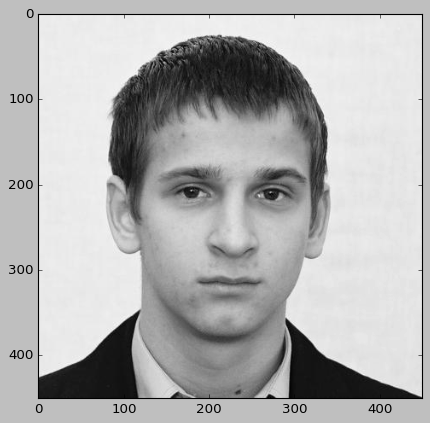

In [42]:
from PIL import Image

plt.style.use('classic')
img = Image.open('AFLW2000/image00053.jpg')
# convert image to grayscale
imggray = img.convert('LA')
# convert to numpy array
imgmat = np.array(list(imggray.getdata(band=0)), float)
print(imgmat.shape)
# Reshape according to orginal image dimensions
imgmat.shape = (imggray.size[1], imggray.size[0])
print(imgmat.shape)
plt.figure(figsize=(9, 6))
plt.imshow(imgmat, cmap='gray')
plt.show()

In [76]:
mylist = [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]
# mylist = lambda x: str(x)+"mat"
# for i in mylist:
#     print(i)


In [77]:
aces = [suit+".mat" for suit in [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]]
# aces

In [157]:
col = [f"point{i}" for i in range(136)]
col = col+["pitch","yaw","roll"]
# col

In [130]:
import pandas as pd

In [150]:
# df = pd.DataFrame(  columns =col )
# # df.loc[0] = mat["pt3d_68"][:-1].reshape(1 , 136)[0]
# df

In [167]:
df = pd.DataFrame( columns =col[:136] )
for i in range(len(aces)):
    mat = scipy.io.loadmat(f'AFLW2000/{aces[i]}')
    df.loc[i] =mat["pt3d_68"][:-1].reshape(1 , 136)[0]
#     df["pitch"] =  mat['Pose_Para'][0][0]
#     df["yaw"] = mat['Pose_Para'][0][1]
#     df["roll"] = mat['Pose_Para'][0][2]

In [170]:
labels_df = pd.DataFrame(columns = col[-3:])
for i in range(len(aces)):
    mat = scipy.io.loadmat(f'AFLW2000/{aces[i]}')
    labels_df.loc[i] =mat['Pose_Para'][0][:3]

In [ ]:
labels_df[:,]

In [172]:
df[col[-3:]] = labels_df

In [178]:
df

,point0,point1,point2,point3,point4,point5,point6,point7,point8,point9,...,point129,point130,point131,point132,point133,point134,point135,pitch,yaw,roll
0,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,310.149048,313.233856,315.107117,322.384613,330.965576,330.701965,324.903870,-0.399231,0.018227,0.085676
1,281.238159,277.339417,274.876953,269.523773,257.788269,240.968155,221.801483,205.846298,207.085449,226.185638,...,303.093811,300.724457,300.060974,303.260895,299.485168,300.598602,302.286499,0.470065,1.189533,0.300959
2,236.385101,239.198257,242.566376,243.971375,242.828186,238.567902,232.561859,229.155289,238.303162,259.122467,...,303.122009,302.877289,302.146454,300.489380,303.481873,304.681732,304.631042,-0.184650,0.881137,-0.236852
3,168.029221,177.697510,190.641602,201.395294,211.957214,222.723099,231.350220,244.332855,268.327637,291.832214,...,315.469391,312.701294,310.133301,300.041290,315.544800,319.498596,320.843994,-0.175379,0.299208,-0.373374
4,280.462250,287.249817,293.892456,297.539368,295.677002,287.270355,271.661591,254.701157,250.219299,261.212463,...,306.811768,307.014893,305.351318,309.934814,311.558899,312.920746,312.058350,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,112.578934,113.787857,119.259262,125.335999,133.637939,146.153839,162.205170,183.907257,213.987427,243.809875,...,317.068970,317.718140,319.277924,321.063141,324.635498,324.518494,322.085815,-0.197102,-0.070430,0.105118
1996,111.117966,113.647079,115.328712,120.565918,134.109467,158.448425,187.568314,212.202332,223.977646,218.683380,...,316.934998,316.013428,315.392395,316.949585,316.981415,317.922302,318.168457,-0.232617,-1.418751,0.175960
1997,308.227417,309.905334,311.432251,310.488586,303.662415,288.275238,268.575409,248.855255,239.939240,248.186981,...,311.084686,311.580597,311.960449,316.873444,314.677002,315.051239,313.333374,-1.447955,1.431267,-1.509418
1998,106.611572,106.089981,107.328842,109.023941,116.216049,136.338547,162.523712,190.193268,208.983047,210.192596,...,309.402283,310.208862,310.287506,312.933044,313.265747,313.581848,312.269653,-0.420465,-1.191176,0.451515


In [179]:
df.to_csv("data.csv")

In [4]:
import numpy as np
X = [1,2,3,4,5,6]
Y = [4,5,6,7,8,9]
points = np.array(X + Y) 
points

array([1, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 9])

In [6]:
points.reshape(1,-1)

array([[1, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 9]])